# Transformer Starter - LB 0.052 - No Feature Engineering
This notebook is a Transformer starter (built upon my WaveNet starter [here][1]). The advantage of using time series deep learning (like CNN, RNN, or Transformer) is that we do not need to do feature engieering! The model does the feature engineeing for us! We input only `num_sold` and the model does the rest! This Transformer model is as accurate as GBDT (like XGB, CAT, LGBM) all on it's own without us engineering any features! Wow!

To make a submission CSV, we need to run this notebook 5 times with `PROD = 0,1,2,3,4`. Each time we train a model for one specific product and predict test for one specific product. Each run loads and saves an intermediate CSV file with partial predicitons. When we run this notebook the fifth time with `PROD=4` then it will write `submission.csv` to submit to comp. 

# New Transformer Model Details
This notebook is a fork of my WaveNet starter [here][1]. Then I made the following changes:
* Replaced WaveNet with Transformer
* Use WaveNet to extract features for Transformer
* Data loader avoids outputting samples with NAN in target
* Train data adds a boolean indicating whether `num_sold` is NAN or not
* Train for 10 epochs using cosine learning schedule
* Use TensorFlow version 2.17.0 instead of 2.13.0

# Old WaveNet Model Details
This notebook uses the following techniques from my WaveNet starter:
* **No feature engineering. Uses the raw `num_sold` time series data only!**
* Train one `Transformer` model for each of the 5 `products`.
* Standardize all 18 time series for each `product` into the same range of values.
* Standardize with `GDP`, `store ratio`, time series `mean`, time series `std`.
* Use all 18 `store` and `country` time series for each `product` to learn about `product`
* `Transformer` takes input time series of length `1440` days and predicts `32` future days
* Infer using `auto regression`. We use predictions to make more predictions 35 times.
* `Transformer` trains with `random crops` from train data
* Train using `2x T4 GPU` and `mixed precision`

# Load Data
Load train data and define which product to train and predict.

[1]: https://www.kaggle.com/code/cdeotte/wavenet-starter-lb-0-08207

In [1]:
# VERSION
VER=1
# WHICH OF 5 PRODUCTS 0,1,2,3,4 TO TRAIN AND PREDICT
PROD = 0
# LENGTH OF TRAIN FEATURES
LEN = 1440

# TRAIN OR LOAD MODEL
TRAIN_MODEL = True
PATH = "/kaggle/input/kaggle-sticker-comp-sub-v2/"
USE_INTERNET = False

In [2]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
train.date = pd.to_datetime(train.date)
print("Train shape:", train.shape )
train.head()

Train shape: (230130, 6)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


id       date country              store             product  num_sold
0   0 2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1 2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2 2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3 2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4 2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0

# Download GDP
We download GDP per country as explained in discussion [here][1]

[1]: https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554349

In [3]:
import requests 
def get_gdp_per_capita(alpha3, year):
    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3,year)).json()
    return response[1][0]['value']

alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
train['alpha3'] = train['country'].map(dict(zip(
    np.sort(train['country'].unique()), alpha3s)))
years = np.sort(train['date'].dt.year.unique())
train['year'] = train['date'].dt.year
if USE_INTERNET:
    gdp = np.array([
        [get_gdp_per_capita(alpha3, year) for year in years]
        for alpha3 in alpha3s
    ])
    gdp = pd.DataFrame(gdp, index=alpha3s, columns=years)
else:
    gdp = pd.read_csv(f"{PATH}gdp0.csv")
    gdp = gdp.set_index("Unnamed: 0")
    gdp = gdp.rename(columns=lambda x: int(x))
train['GDP'] = train.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)
train = train.drop(['alpha3','year'],axis=1)
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


id       date country              store             product  num_sold  \
0   0 2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN   
1   1 2010-01-01  Canada  Discount Stickers              Kaggle     973.0   
2   2 2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0   
3   3 2010-01-01  Canada  Discount Stickers            Kerneler     423.0   
4   4 2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0   

            GDP  
0  47560.666601  
1  47560.666601  
2  47560.666601  
3  47560.666601  
4  47560.666601

# Standardize with GDP and Store Ratio
We now divide each `num_sold` by it's countries GDP, this normalizes all the `num_sold` and makes different countries have similar values so we can use all the data together to train our model. We also normalize per store by dividing by each store's percentage of total sales.

After these two normalizations, then all 18 country store combinations will have `num_sold` values that are similar and we can train with everything together.

In [4]:
train["num_sold"] /= train["GDP"]
store_ratio = train.groupby("store").num_sold.mean().to_dict()
train["store_ratio"] = train.store.map(store_ratio)
train["num_sold"] /= train["store_ratio"]

# Create Train Data (standardize with mean and std)
We will standarize all time series by subtracting mean and dividing by standard deviation for training (to get mean=0 and std=1). Additionally we multiply Kenya by 1.15 because even after GDP normalization (in above code cell), Kenya predictions are lower than other countries. 

Later, after making test predictions, we reverse this by dividing Kenya predictions by 1.15 in code cell #15. And we reverse standardization by multiplying by standard deviation and adding mean (which we save now for later).

Countries: ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
Stores: ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart']
Products: ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']


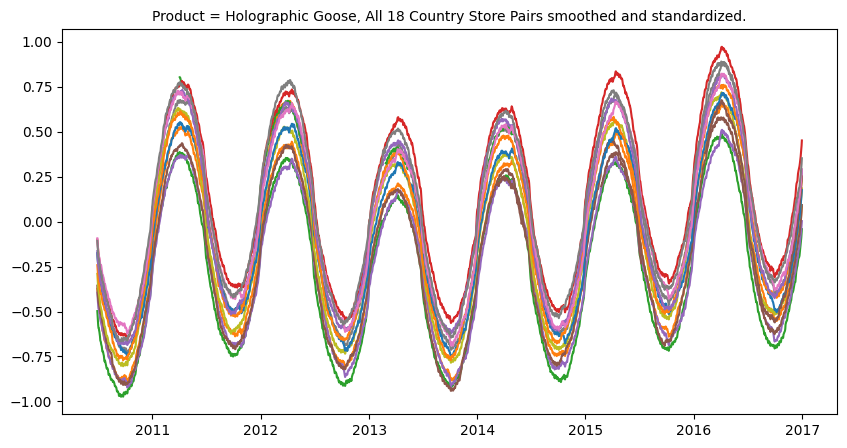

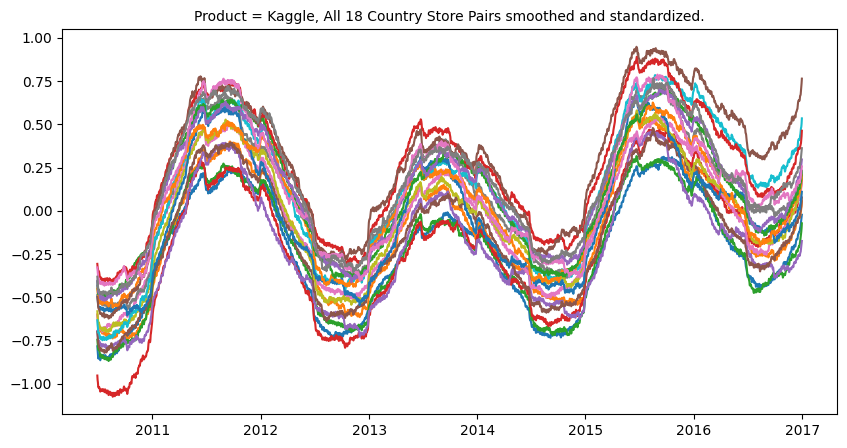

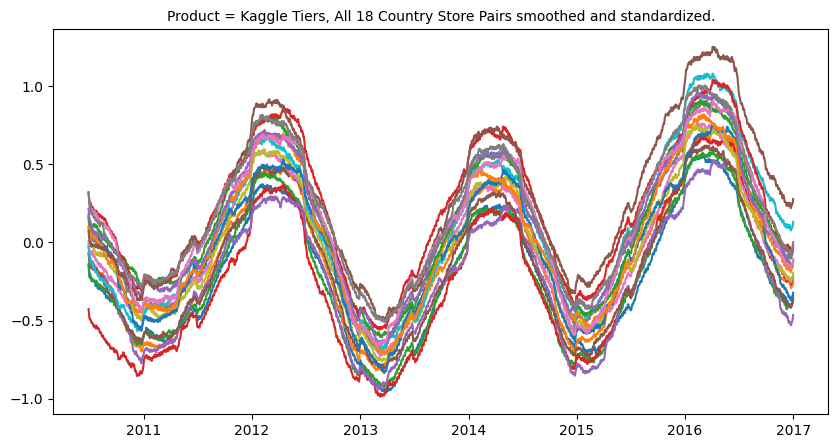

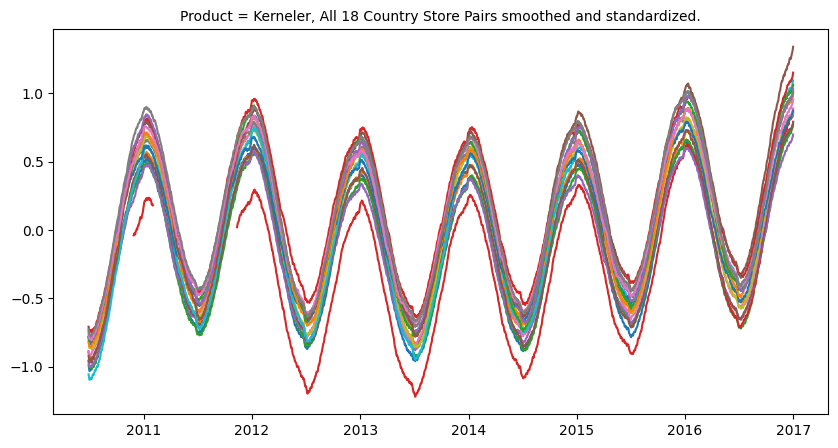

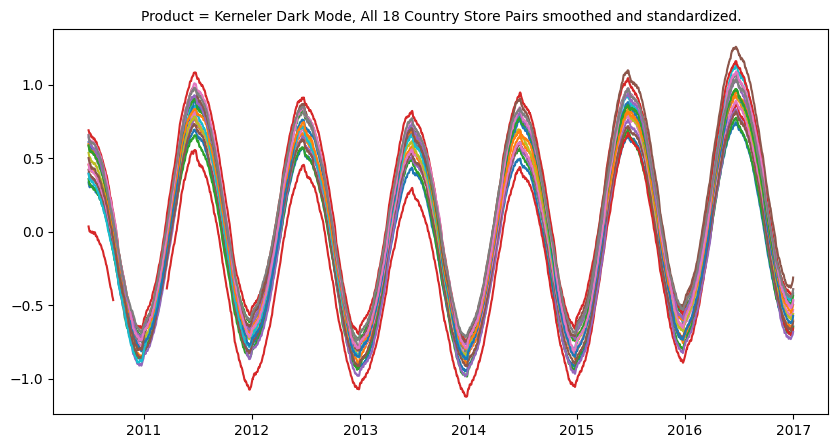

In [5]:
C = list( train.country.unique() )
S = list( train.store.unique() )
P = list( train["product"].unique() )
print("Countries:", C )
print("Stores:", S )
print("Products:", P)

# DATA IS PRODUCT X 7 YEARS X STORE+COUNTRY
data = np.zeros( (5,2557,18) )
for i in range(5):
    for j in range(3):
        for k in range(6):
            f = 1 
            if k==3: f=1.15 # FUDGE FACTOR FOR KENYA
            df = train.loc[(train.country==C[k])&(train.store==S[j])&(train["product"]==P[i])].copy()
            data[i,:,j*6+k] = df["num_sold"].values*f

# COMPUTE MEANS AND STDS
means = {}; stds = {}
for k in range(5):
    m = np.nanmean( data[k,:,:] )
    s = np.nanstd( data[k,:,:] )
    means[k]=m; stds[k]=s

# PLOT ALL TIME SERIES DATA
for i in range(5):
    plt.figure(figsize=(10,5))
    for j in range(3):
        for k in range(6):
            f = 1
            if k==3: f=1.15
            df = train.loc[(train.country==C[k])&(train.store==S[j])&(train["product"]==P[i])].copy()
            df["smooth_sold"] = df["num_sold"].rolling(window=180).mean()
            m = means[i]; s = stds[i]
            plt.plot(df["date"], (df["smooth_sold"]*f-m)/s )
            data[i,:,j*6+k] = (df["num_sold"].values*f-m)/s
    plt.title(f"Product = {P[i]}, All 18 Country Store Pairs smoothed and standardized.",size=10)
    plt.show()

# Data Loader
We will make a dataloader to train our Transformer NN. This can be improved. Currently we just take 32x1024 `random crops` from the train data per epoch. We avoid outputting samples where target contains NAN.

In [6]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, product=0, f_length=768, t_length=32): 

        self.data = np.expand_dims(data,axis=-1)
        nans = np.isnan(self.data).astype('float32')
        self.data = np.concatenate([self.data,nans],axis=-1)
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.product = product
        self.f_length = f_length
        self.t_length = t_length
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int(np.ceil(32*1024/self.batch_size))
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( 32*1024 )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        SIZE = self.f_length
        TARGET = self.t_length
        X = np.zeros((len(indexes),SIZE,2),dtype='float32')
        y = np.zeros((len(indexes),TARGET),dtype='float32')
        
        for k in range(len(indexes)):
            r = np.random.randint(0,self.data.shape[2])
            a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
            y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            while np.isnan(y[k,:]).sum()>0:
                r = np.random.randint(0,self.data.shape[2])
                a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
                y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            X[k,:,:] = self.data[self.product,a:a+SIZE,r,:]

        return np.nan_to_num(X),np.nan_to_num(y)

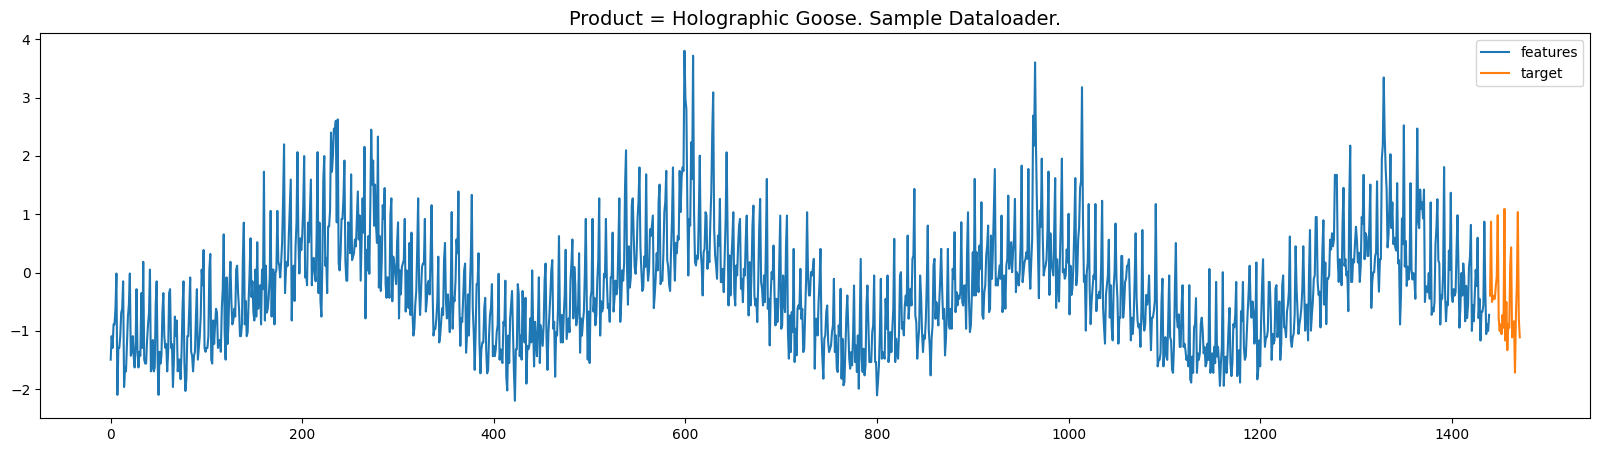

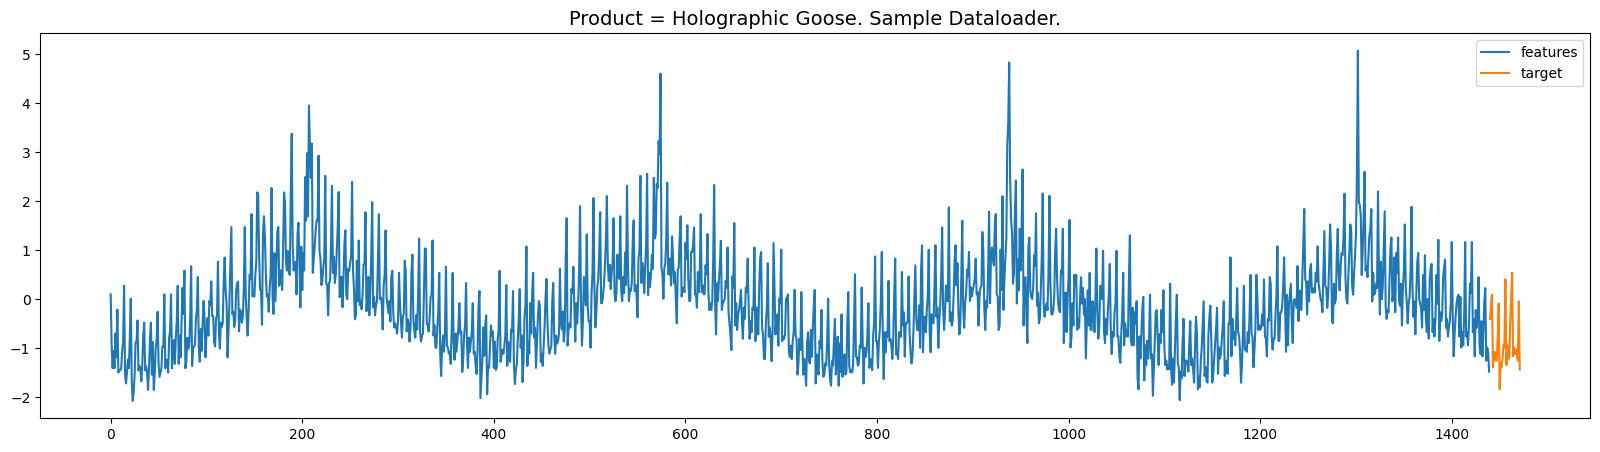

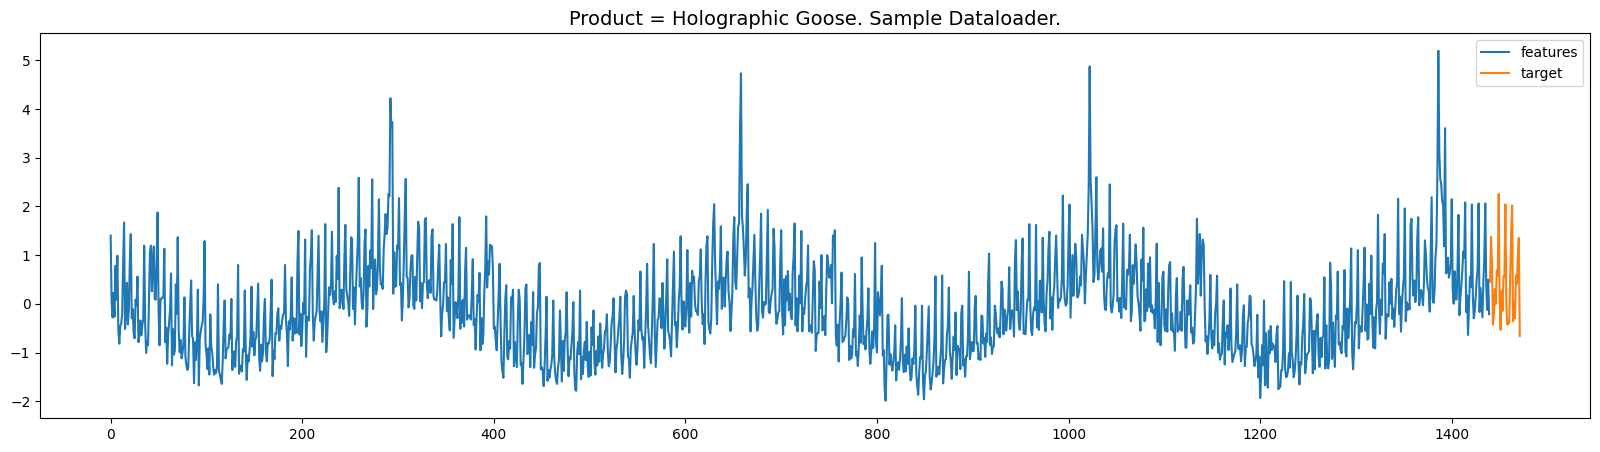

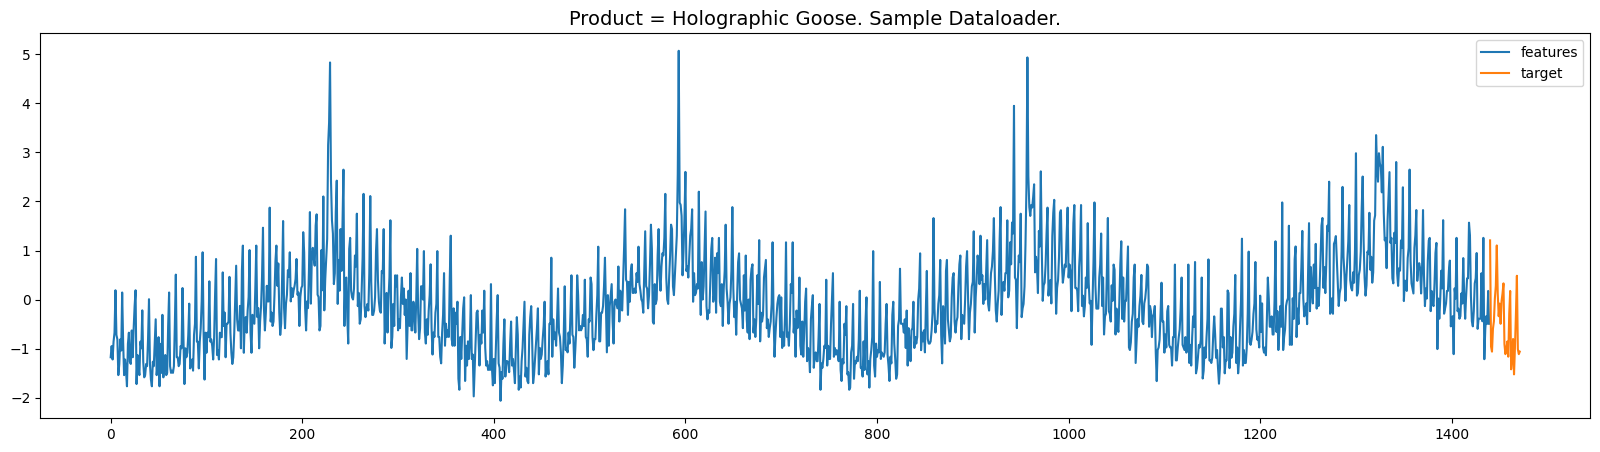

In [7]:
# DISPLAY DATA LOADER
gen = DataGenerator(data, shuffle=False, f_length=LEN, product=PROD)
for x,y in gen:
    for k in range(4):
        plt.figure(figsize=(20,5))
        LN = x.shape[1]
        LN2 = y.shape[1]
        plt.plot(np.arange(LN),x[k,:,0],label='features')
        plt.plot(np.arange(LN2)+LN,y[k,:],label='target')
        plt.legend()
        plt.title(f"Product = {P[PROD]}. Sample Dataloader.",size=14)
        plt.show()
    break

# Train Schedule
We use cosine learning schedule and train our transformer for 10 epochs.

Learning rate schedule: 0.001 to 0.001 to 1e-06


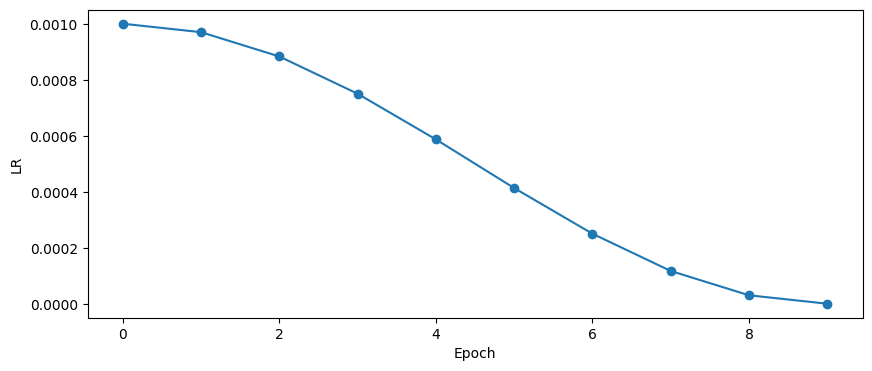

In [8]:
import math, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# Build Transformer Layers
This code is from my gold medal solution to Brain comp [here][1] with discussion [here][2]

[1]: https://www.kaggle.com/code/cdeotte/11th-place-gold-cv-835-public-lb-788
[2]: https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/459596

In [9]:
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version",tf.__version__)

Tensorflow version 2.17.1


In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):  
        attn_output = self.att(inputs, inputs, training=training)  
        attn_output = self.dropout1(attn_output, training=training)  
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)  
        return self.layernorm2(out1 + ffn_output)

In [11]:
def positional_encoding(maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

# Build WaveNet Layers
We will use WaveNet layers to extract features for our transformer layers. This code is from my gold medal solution to Brain comp [here][1] with discussion [here][2]

[1]: https://www.kaggle.com/code/cdeotte/11th-place-gold-cv-835-public-lb-788
[2]: https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/459596

In [12]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

# Build Transformer Model
This model is based on my model from gold medal solution to Brain comp [here][1] with discussion [here][2]

[1]: https://www.kaggle.com/code/cdeotte/11th-place-gold-cv-835-public-lb-788
[2]: https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/459596

In [13]:
feat_dim = 16 
embed_dim = 32  
num_heads = 4  
ff_dim = 64
dropout_rate = 0.0
num_blocks = 3

def build_model():
        
    # INPUT 
    inp = tf.keras.Input(shape=(LEN,2))
    
    # POSITIONAL ENCODING
    x = layers.Dense(feat_dim)(inp)
    p = positional_encoding(1440,feat_dim)
    x = x + p
    
    # THREE BLOCKS of WAVENET and TRANSFORMER
    for k in range(num_blocks):
        skip = x
        x = wave_block(x, feat_dim, 3, 12)
        x = wave_block(x, feat_dim, 3, 12)
        x = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)(x)
        x = 0.9*x + 0.1*skip 

    # HEAD
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32,activation='linear', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer = opt)
    
    return model

# Initialize GPUs
We will use both 2x T4 Kaggle GPUs. And we will enable mixed precision. This will speed up training.

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

TensorFlow version = 2.17.1
Using 2 GPUs


In [15]:
# USE MIXED PRECISION
from tensorflow.keras.mixed_precision import set_global_policy

policy = 'mixed_float16'
set_global_policy(policy)
print(f"Mixed precision policy set to: {policy}")

Mixed precision policy set to: mixed_float16


# Train Model
We train without proper validation. The validation data overlaps the train data. We need to update this to proper validation. One way to create a non-overlapping train and valid data is to use 6 KFolds. During each of the 6 folds, we train with 5 countries and validate on the other 1 country. This is not a time series cross validation but it could work here and allow us to use maximum time data to train our models.

In [16]:
os.makedirs(f'models_v{VER}', exist_ok=True)

train_gen = DataGenerator(data, shuffle=True, batch_size=64, f_length=LEN, product=PROD)
valid_gen = DataGenerator(data, shuffle=False, batch_size=128, f_length=LEN, product=PROD)

with strategy.scope():
    model = build_model()
if TRAIN_MODEL:
    model.fit(train_gen, verbose=1,
          validation_data = valid_gen,
          epochs=EPOCHS, callbacks = [LR])
    model.save_weights(f'models_v{VER}/model_v{VER}_p{PROD}.weights.h5')
else:
    model.load_weights(f'{PATH}model_v{VER}_p{PROD}.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 416s 616ms/step - loss: 0.7645 - val_loss: 0.5218 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009698764640825614.
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 307s 600ms/step - loss: 0.5095 - val_loss: 0.4976 - learning_rate: 9.6988e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008831391993379295.
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 307s 599ms/step - loss: 0.4963 - val_loss: 0.4922 - learning_rate: 8.8314e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007502500000000002.
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 307s 600ms/step - loss: 0.4870 - val_loss: 0.4793 - learning_rate: 7.5025e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005872372647446319.
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 309s 603ms/step - loss: 0.4659 - val_loss: 0.3677 - learning_rate: 5.8724e-04

Epoch 6: LearningRateSchedule

# Predict Test
We predict and display predictions. We iterate over each country store pair. Train data was standardized so test predictions will be standarized. We will "un-standardize" test predictions below.

We predict using `auto regression`. Our model predicts 32 days into the future. Then we use those predictions together with train data to predict another 32 days into the future. We repeat this process 35 times to predict 3 years into the future.

In [17]:
# ADD NAN INDICATOR FEATURE TO DATA
data = np.expand_dims(data,axis=-1)
nans = np.isnan(data).astype('float32')
data = np.concatenate([data,nans],axis=-1)

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


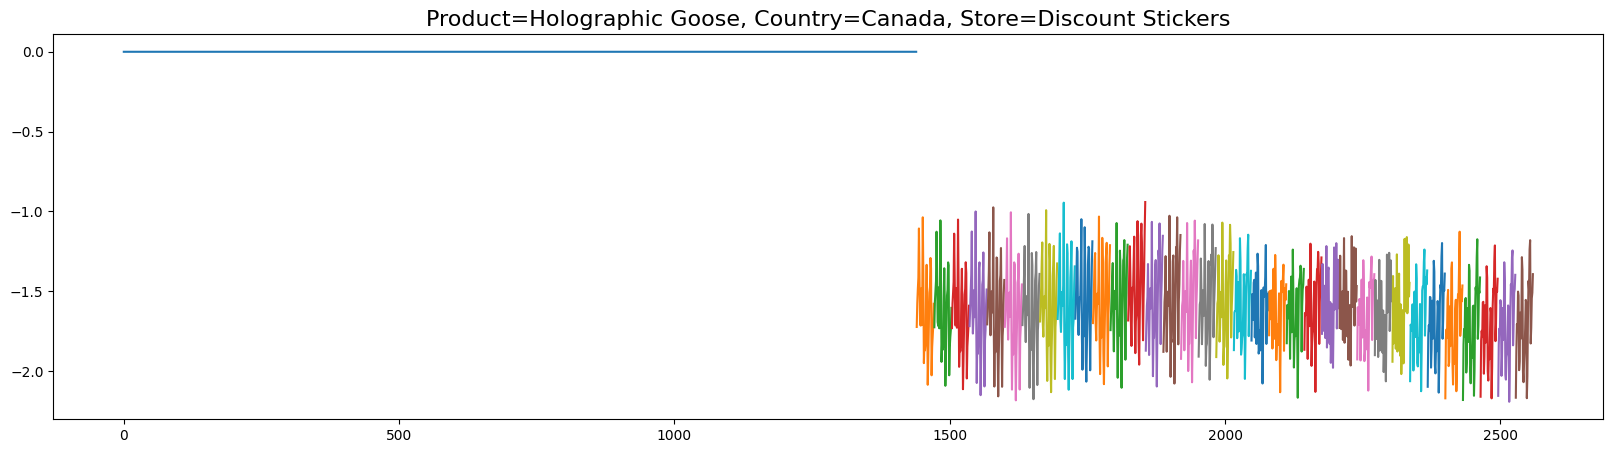

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


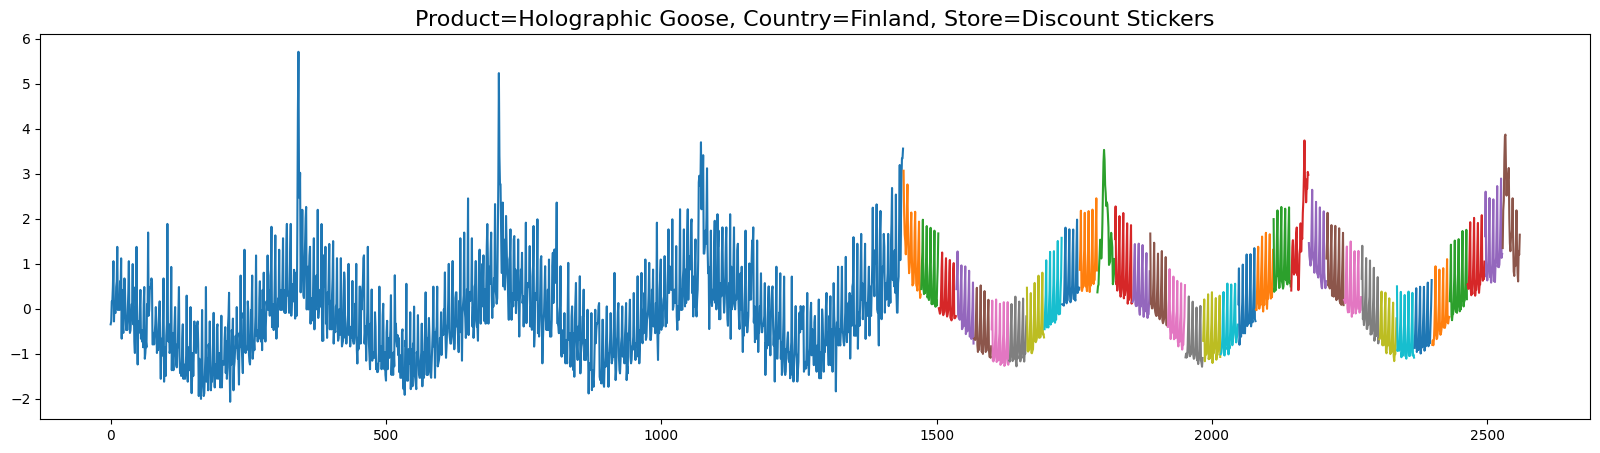

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


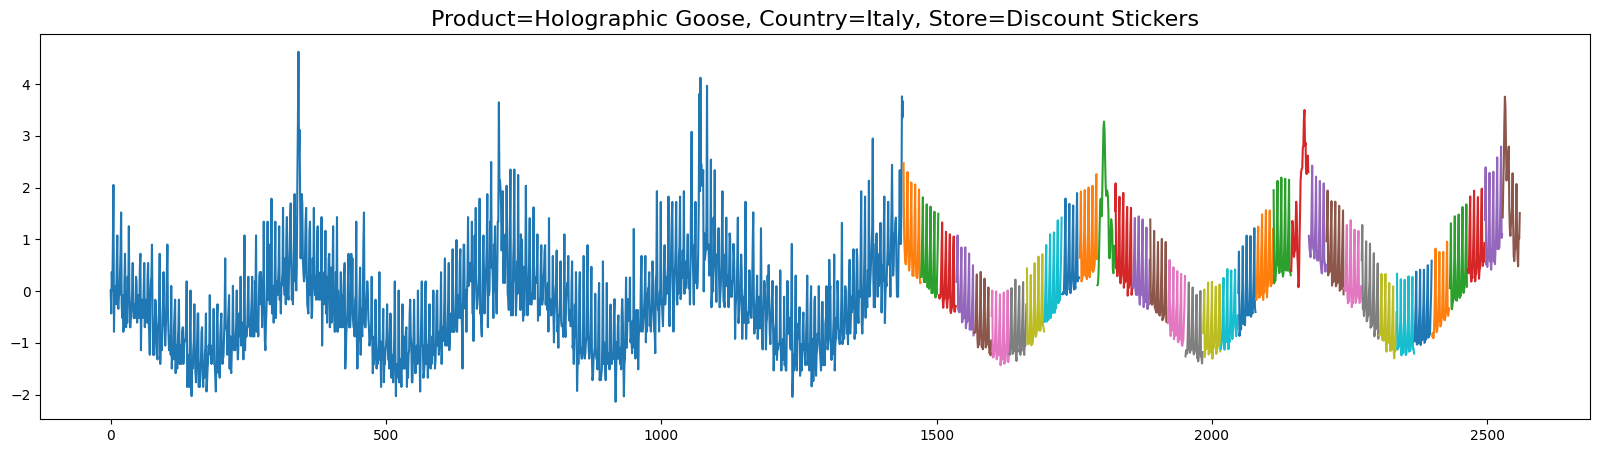

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


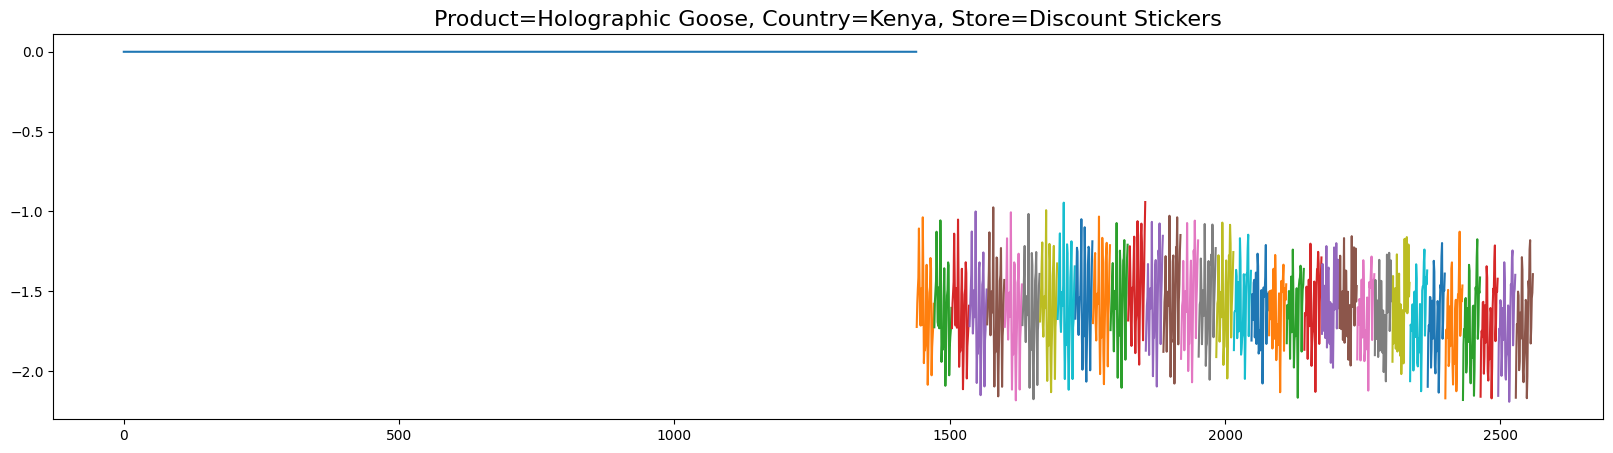

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


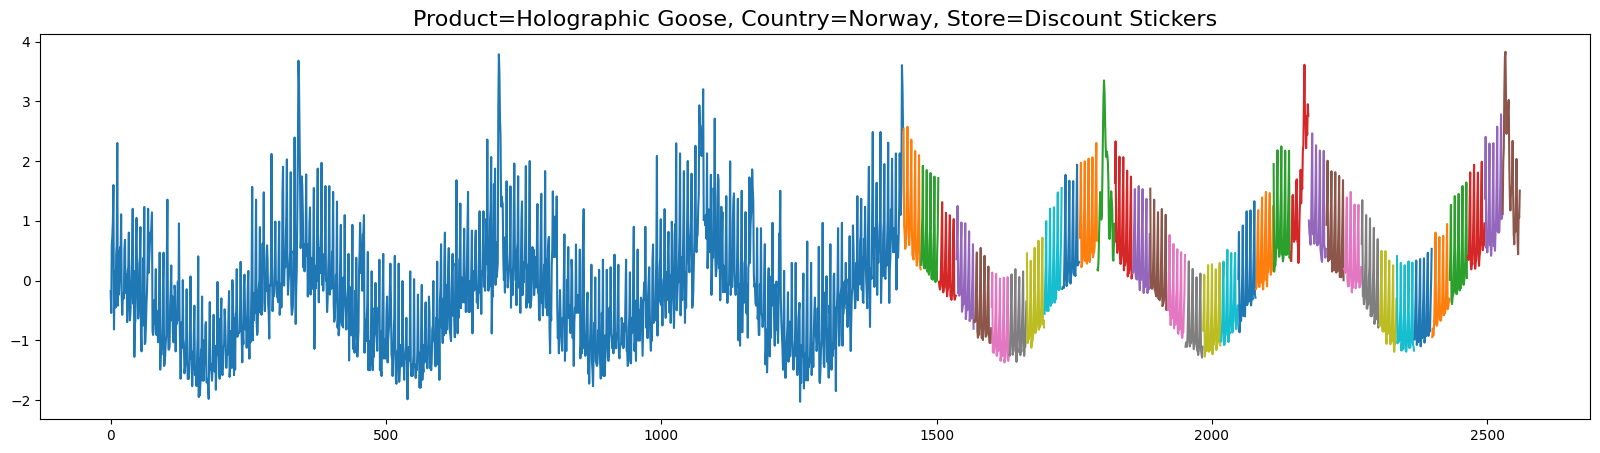

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


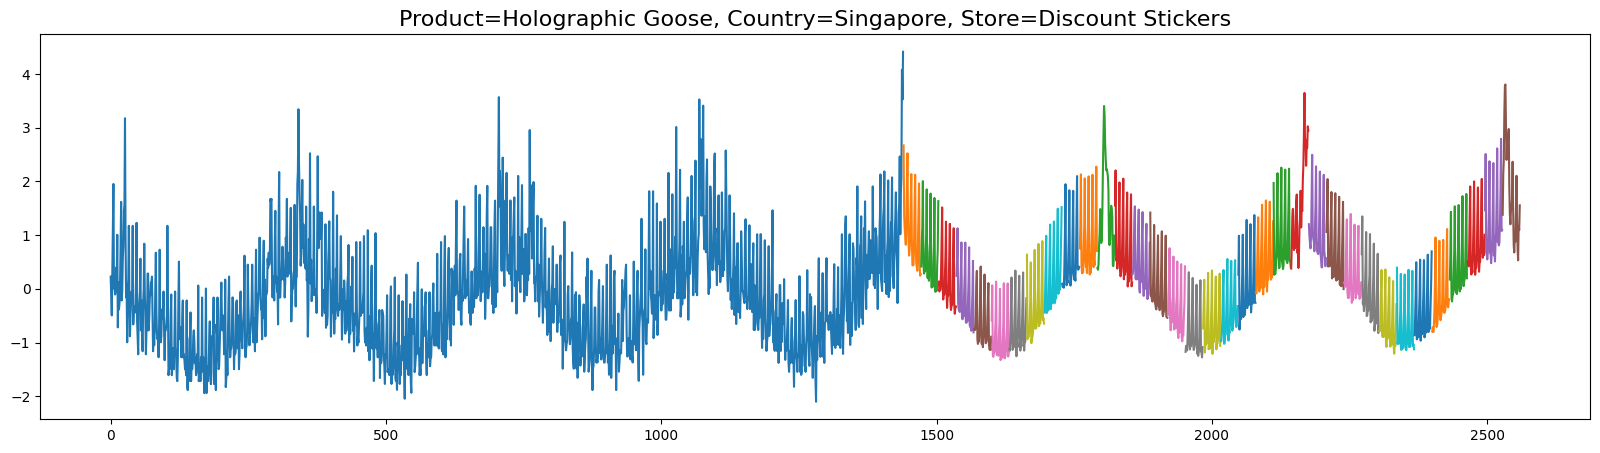

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


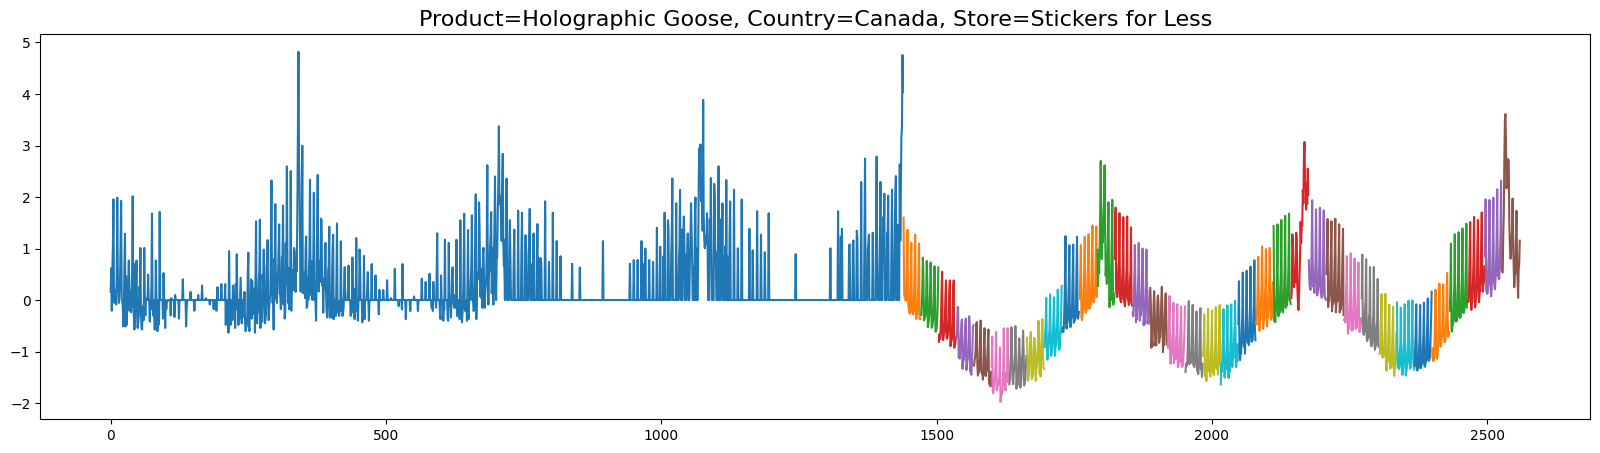

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


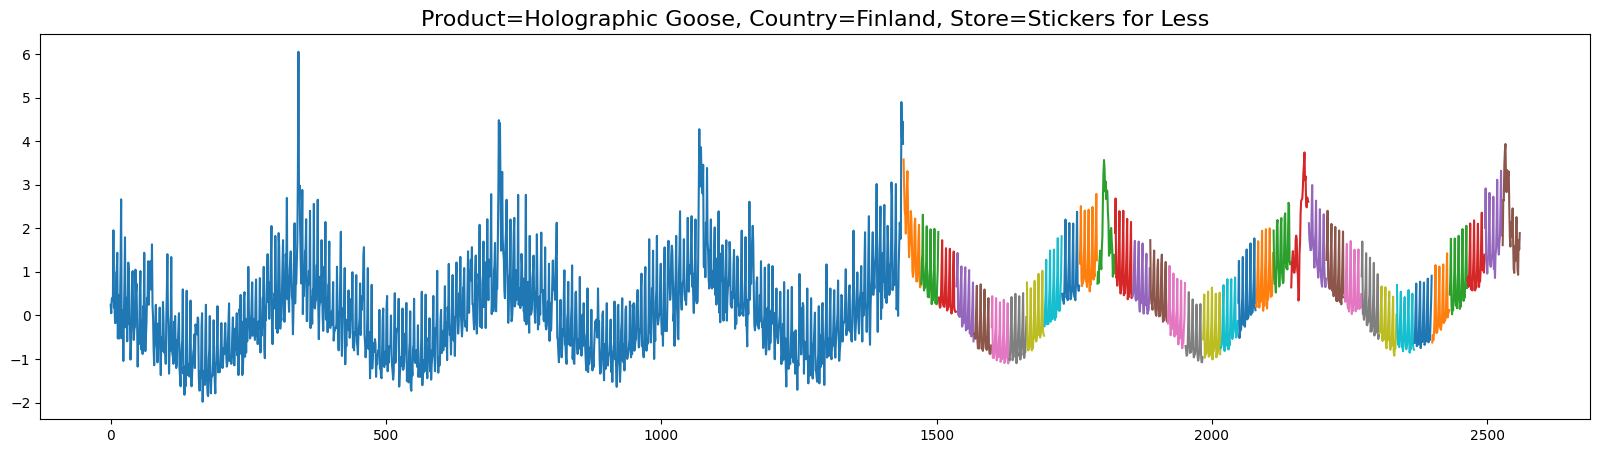

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


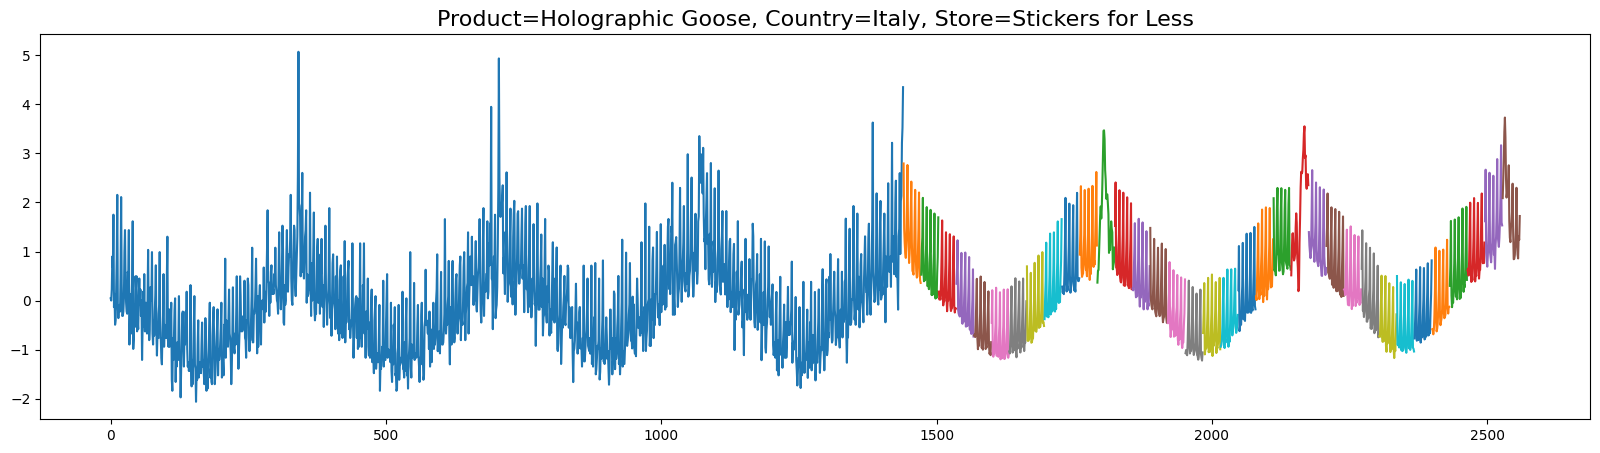

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


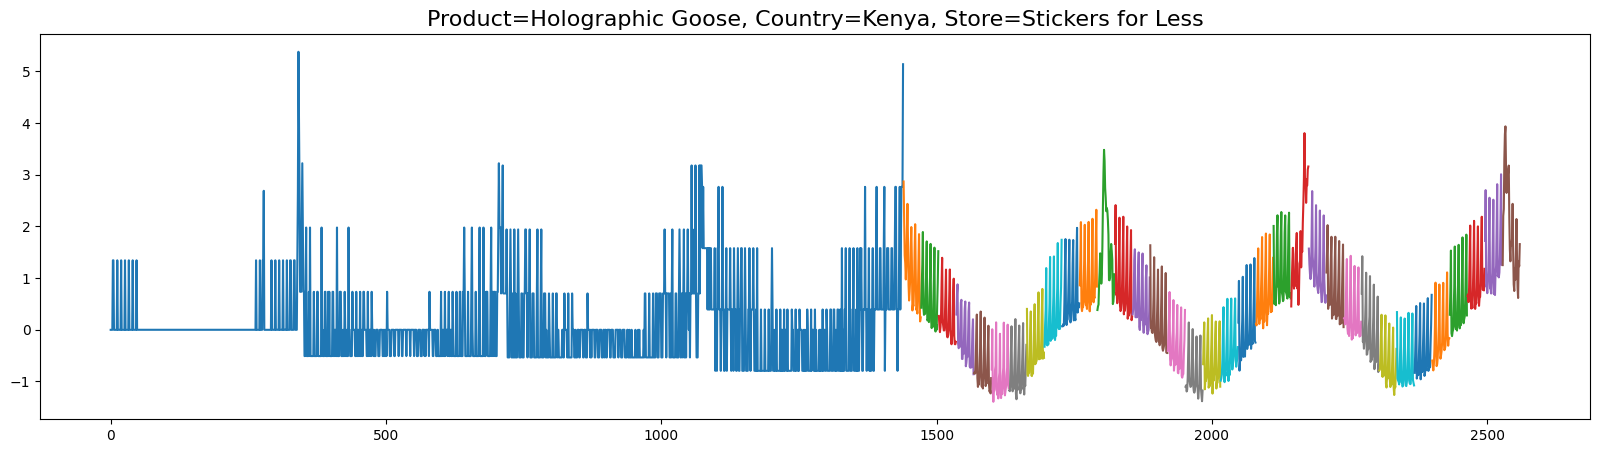

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


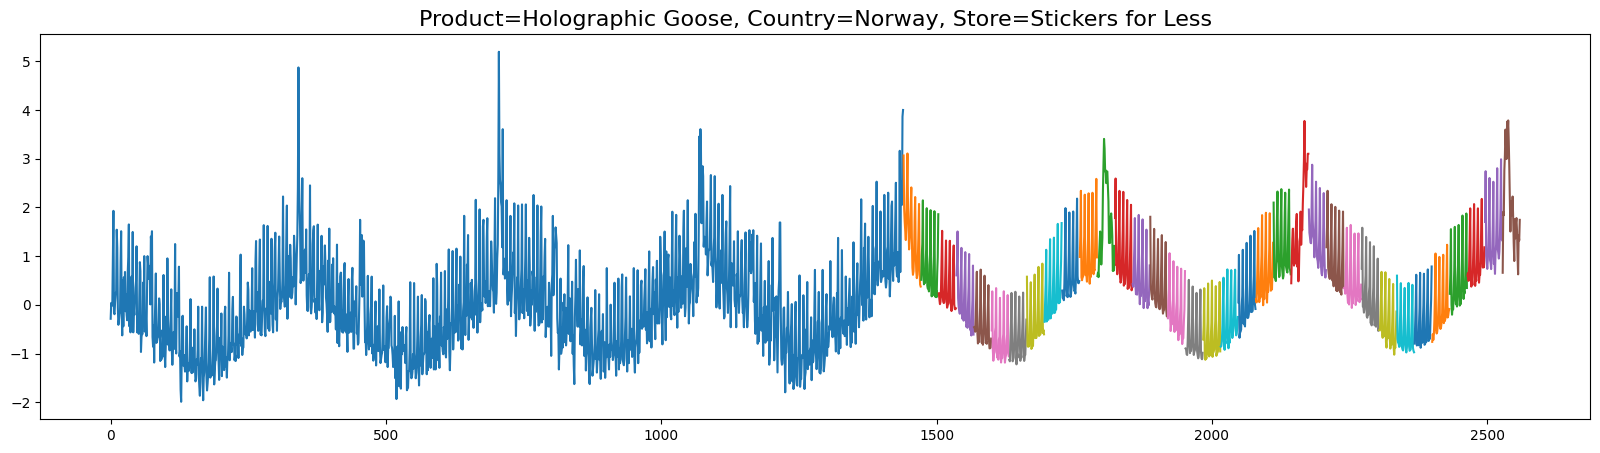

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


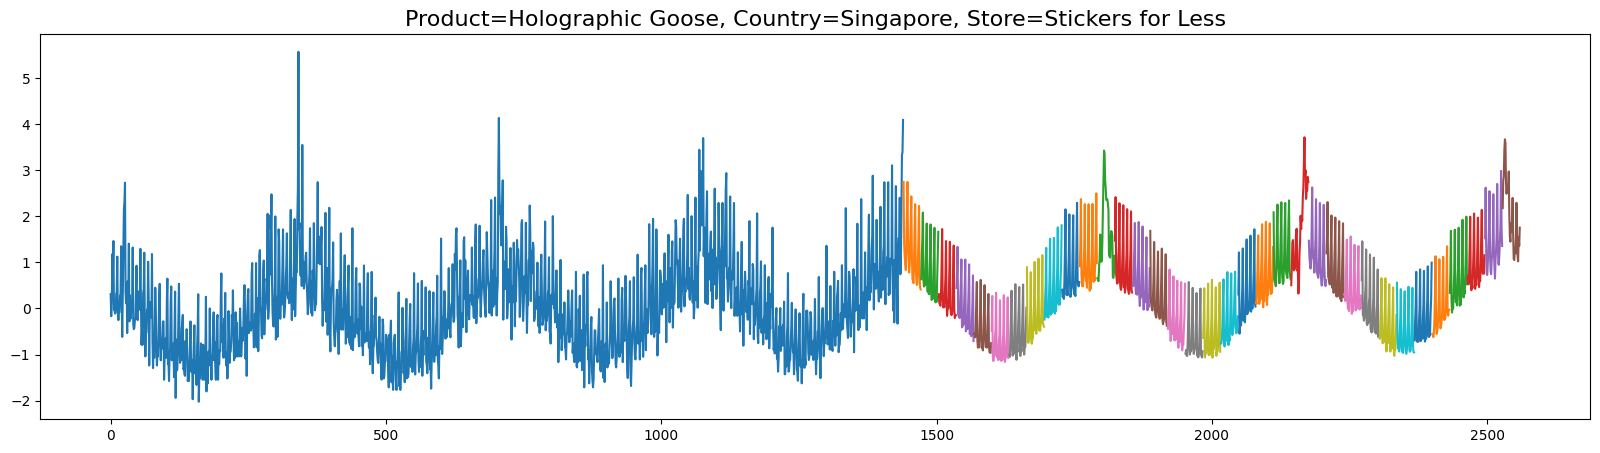

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


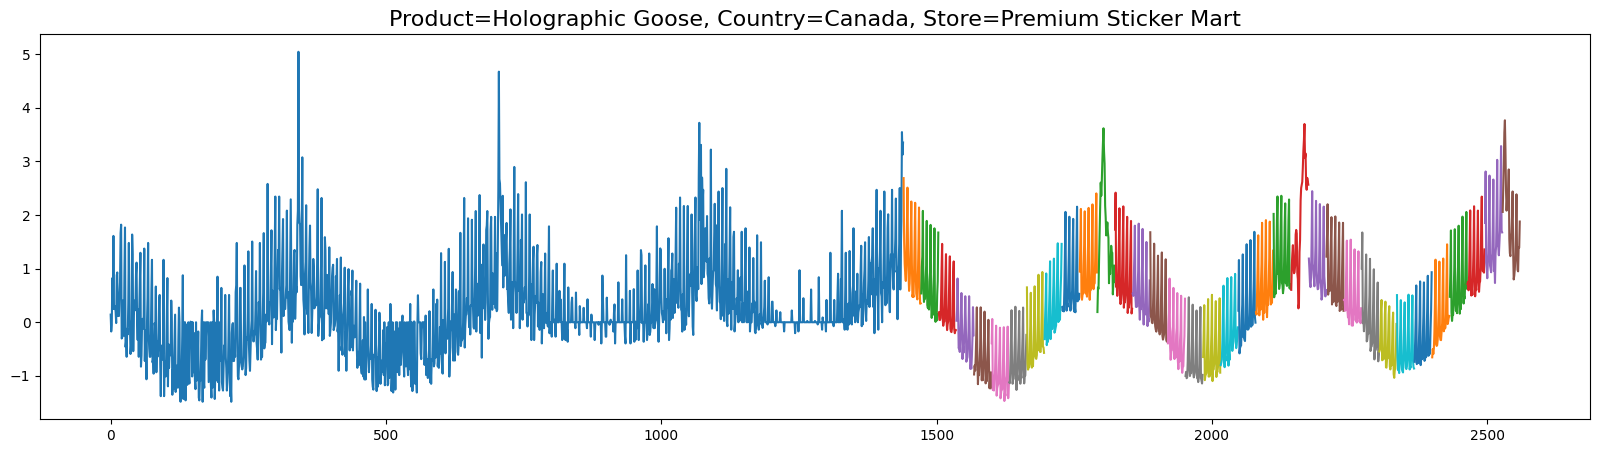

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


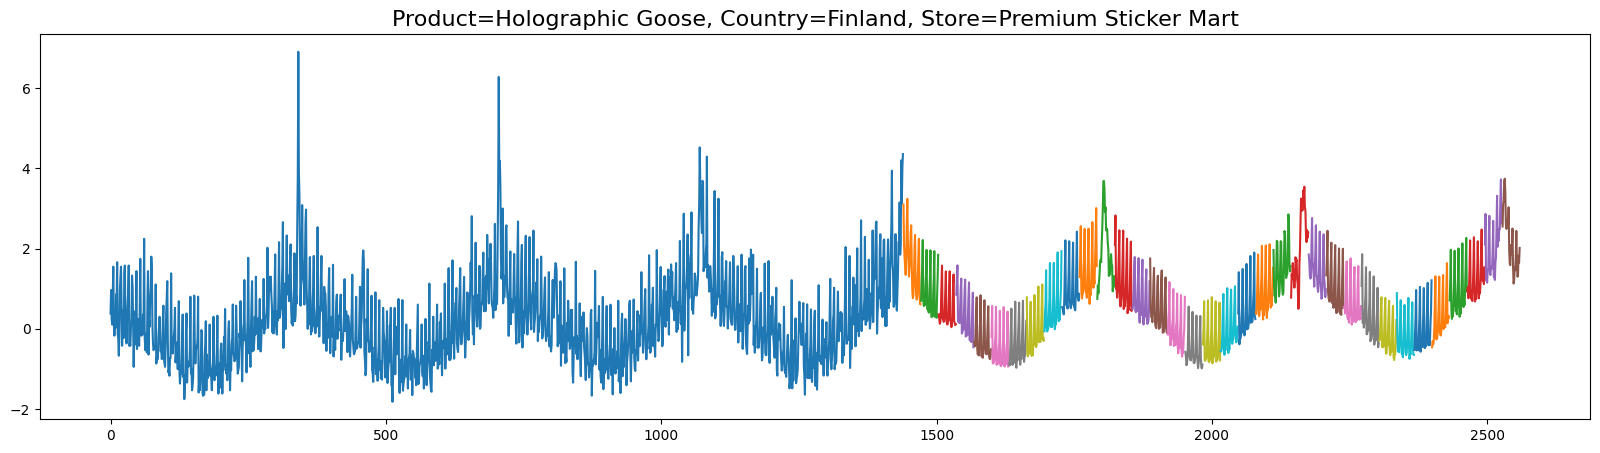

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


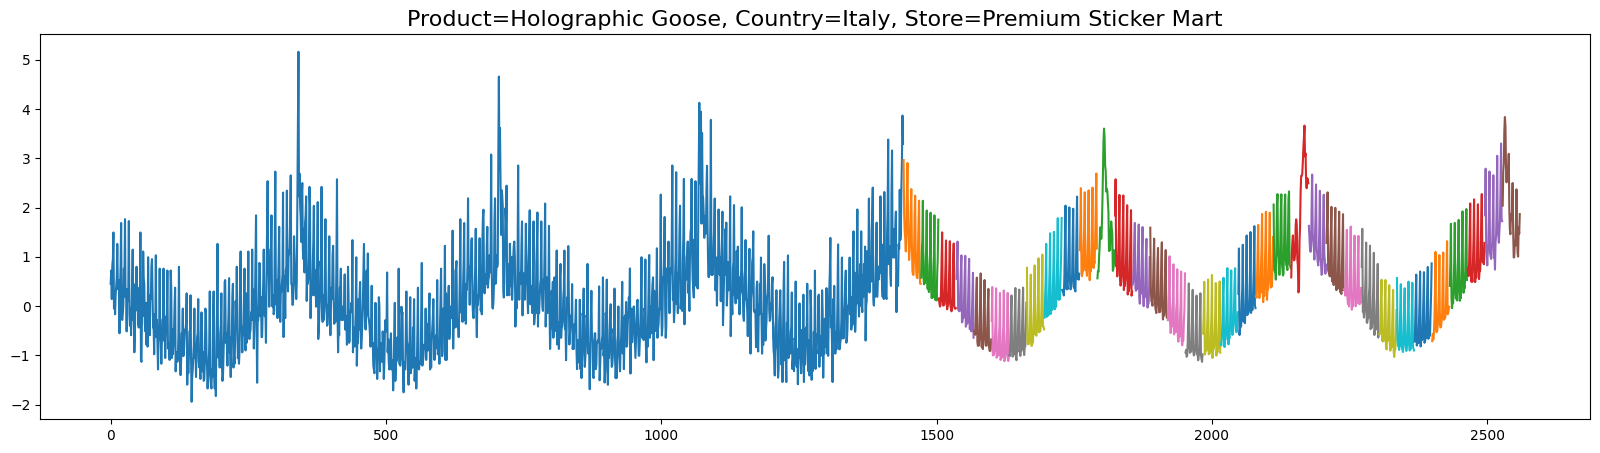

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


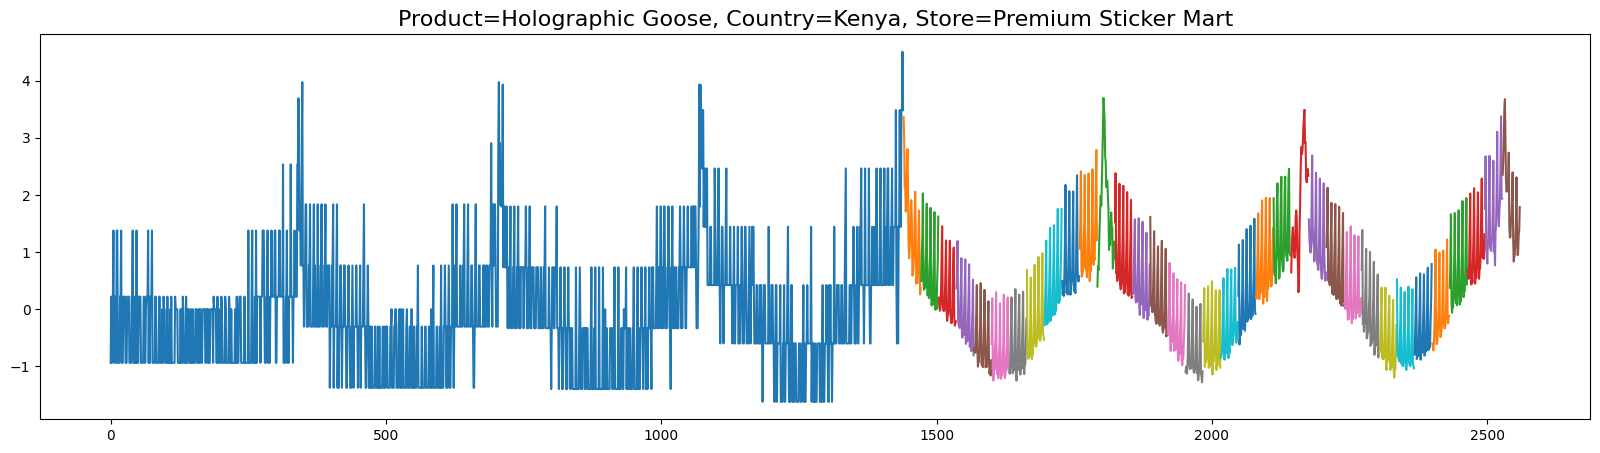

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


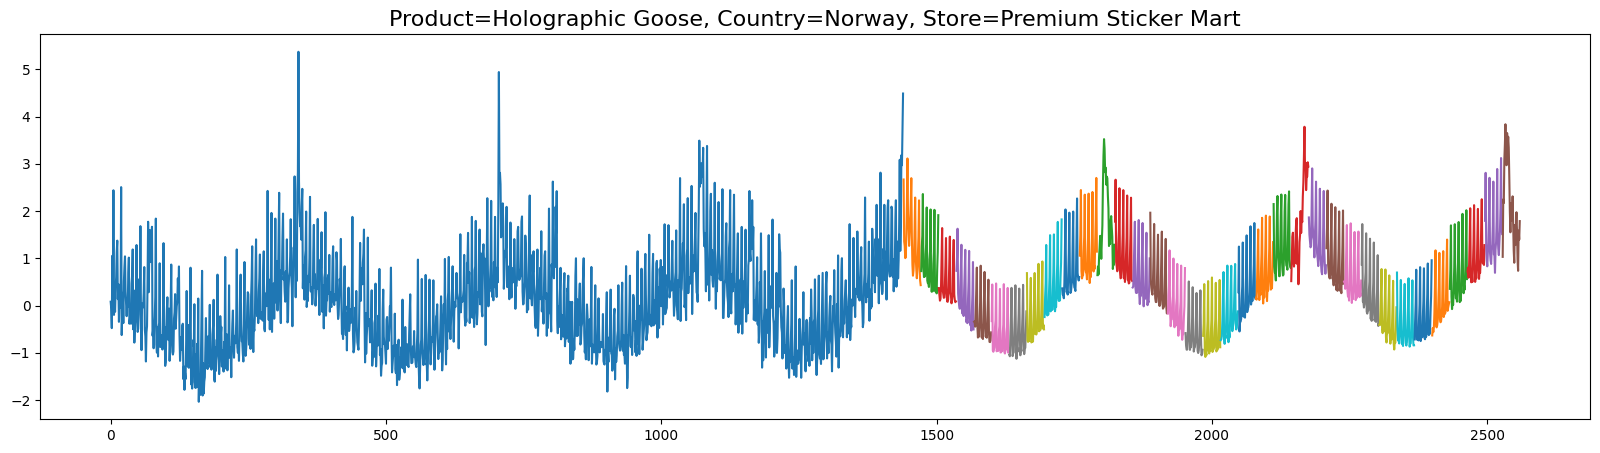

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 


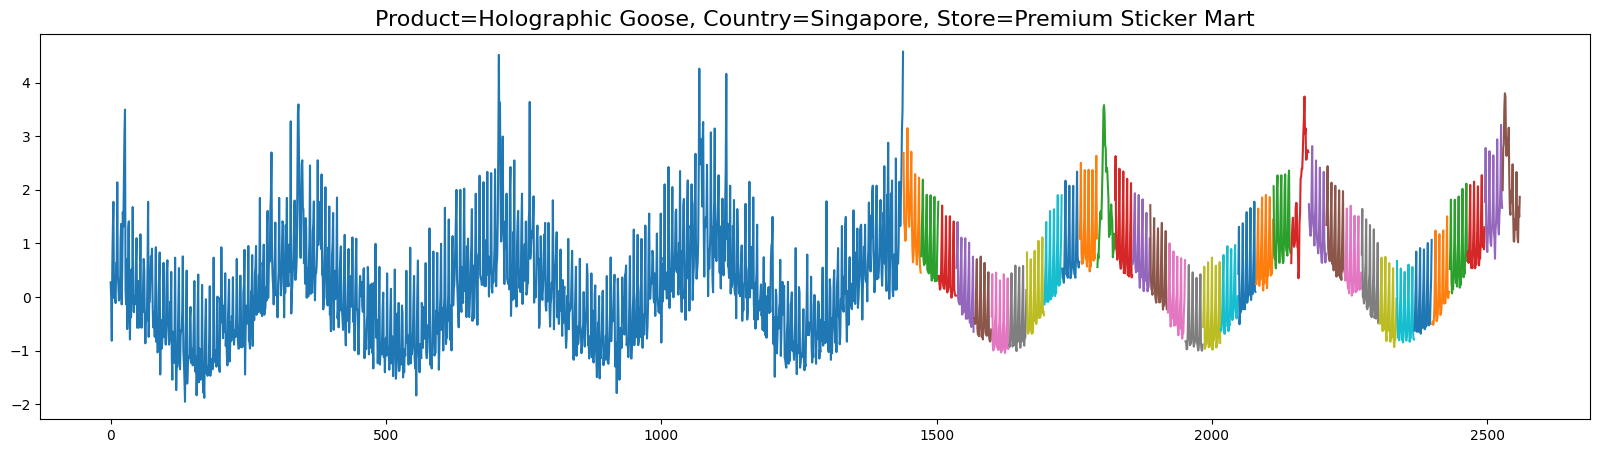

In [18]:
preds = np.zeros((18,32*35))

# ITERATE OVER ALL COMBINATIONS OF COUNTRY AND STORE FOR SPECIFIC PRODUCT
# PREDICT 3 YEARS INTO THE FUTURE

bad_rows = []
for jj in range(18):
    ddd0 = data[PROD:PROD+1,-LEN:,jj,:].copy()
    if np.isnan(ddd0[:,:,0]).sum()==LEN:
        bad_rows.append(jj)
    
    pp = []
    for j in range(0,35):
        print(j,", ",end="")
        if j==0: dd2 = ddd0
        else: dd2 = np.concatenate([ddd0[:,32*j:,:]]+pp,axis=1) 
        p2 = model.predict( np.nan_to_num(dd2[:,-LEN:,:]) ,verbose=0)
        p2 = p2.reshape((1,32,1)) # ADD NAN INDICATOR TO PREDICTIONS
        p2 = np.concatenate([p2,np.zeros_like(p2)],axis=-1)
        pp.append(p2)
        if j==34:
            print()
            plt.figure(figsize=(20,5))
            plt.plot(np.arange(LEN), np.nan_to_num(ddd0[0,:,0]) )
            for k in range(j+1):
                plt.plot(np.arange(32)+LEN+32*k,pp[k][0,:,0])
            cc = C[jj%6]
            ss = S[jj//6]
            plt.title(f"Product={P[PROD]}, Country={cc}, Store={ss}",size=16)
            plt.show()
            
    preds[jj,:] = np.concatenate([z[:,:,:1] for z in pp],axis=1).flatten() 

# Reverse Standardize
We standarized the train data by minus mean divide std. So now before we can submit predictions, we need to reverse this with multiply std and add mean to preds. Also we need to reverse our Kenya fudge factor. When all train features are NAN, we convert predictions to the average prediction.

In [19]:
# FILLNAN PREDS
FILLNAN = np.nanmean(preds,axis=0)
for r in bad_rows:
    preds[r,:] = FILLNAN

# REVERSE STANDARIZE PREDICTIONS AND FIX KENYA
preds = (preds*stds[PROD])+means[PROD]
for i in [3,9,15]: preds[i,:] = preds[i,:]/1.15

# Create Submission File

In [20]:
if PROD==0:
    test = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv")
    test.date = pd.to_datetime(test.date)
    test['alpha3'] = test['country'].map(dict(zip(
        np.sort(test['country'].unique()), alpha3s)))
    years = np.sort(test['date'].dt.year.unique())
    test['year'] = test['date'].dt.year
    if USE_INTERNET:
        gdp = np.array([
            [get_gdp_per_capita(alpha3, year) for year in years]
            for alpha3 in alpha3s
        ])
        gdp1 = pd.DataFrame(gdp, index=alpha3s, columns=years)
    else:
        gdp1 = pd.read_csv(f"{PATH}gdp1.csv")
        gdp1 = gdp1.set_index("Unnamed: 0")
        gdp1 = gdp1.rename(columns=lambda x: int(x))
    test['GDP'] = test.apply(lambda s: gdp1.loc[s['alpha3'], s['year']], axis=1)
    test["num_sold"] = 0.0
else:
    test = pd.read_csv(f"test_v{VER}_p{PROD-1}.csv")
    test.date = pd.to_datetime(test.date)

# Reverse GDP, Store Ratio
We divided train by GDP and divided train by Store Ratio, so we need to reverse this and multiple test by GDP and multiply test by Store Ratio

In [21]:
for i in range(3):
    for j in range(6):
        test.loc[(test['product']==P[PROD])&(test.store==S[i])&(test.country==C[j]),'num_sold'] =\
            preds[i*6+j,:1095]
test["store_ratio"] = test.store.map(store_ratio)
test.loc[test['product']==P[PROD],"num_sold"] =\
    test.loc[test['product']==P[PROD],"num_sold"] * test.loc[test['product']==P[PROD],"GDP"]
test.loc[test['product']==P[PROD],"num_sold"] =\
    test.loc[test['product']==P[PROD],"num_sold"] * test.loc[test['product']==P[PROD],"store_ratio"]

print( test.shape )
display( test.head() )

(98550, 10)


id       date country              store             product alpha3  \
0  230130 2017-01-01  Canada  Discount Stickers   Holographic Goose    CAN   
1  230131 2017-01-01  Canada  Discount Stickers              Kaggle    CAN   
2  230132 2017-01-01  Canada  Discount Stickers        Kaggle Tiers    CAN   
3  230133 2017-01-01  Canada  Discount Stickers            Kerneler    CAN   
4  230134 2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode    CAN   

   year           GDP    num_sold  store_ratio  
0  2017  45129.628117  128.546359     0.008957  
1  2017  45129.628117    0.000000     0.008957  
2  2017  45129.628117    0.000000     0.008957  
3  2017  45129.628117    0.000000     0.008957  
4  2017  45129.628117    0.000000     0.008957

# Display Test Predictions
These are train and test data without any standardization.

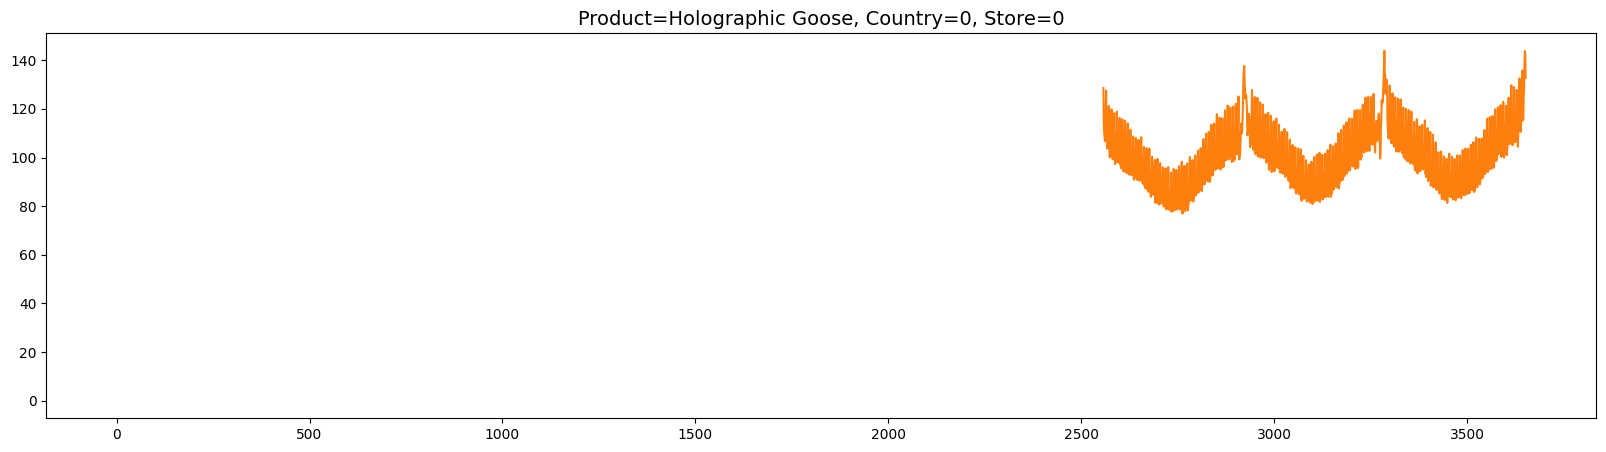

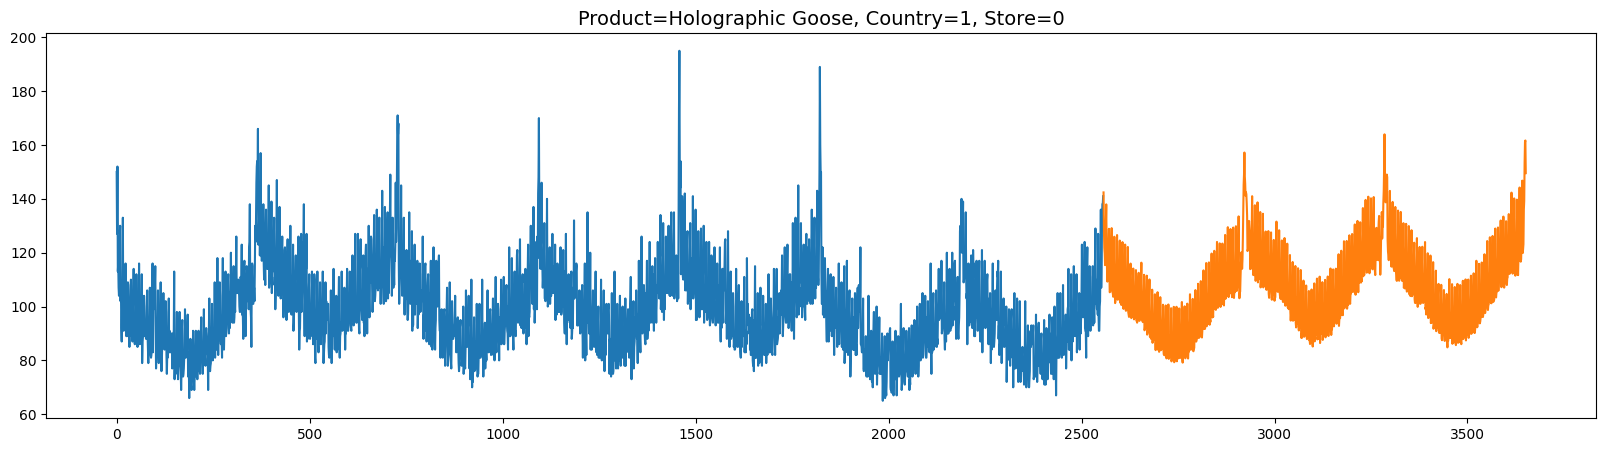

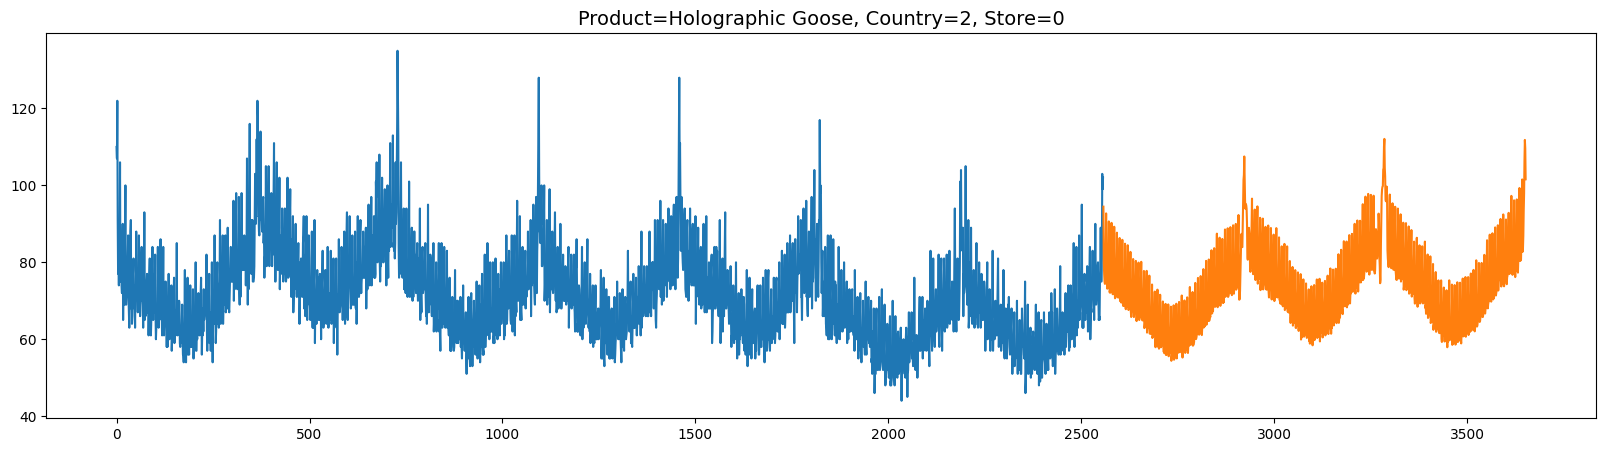

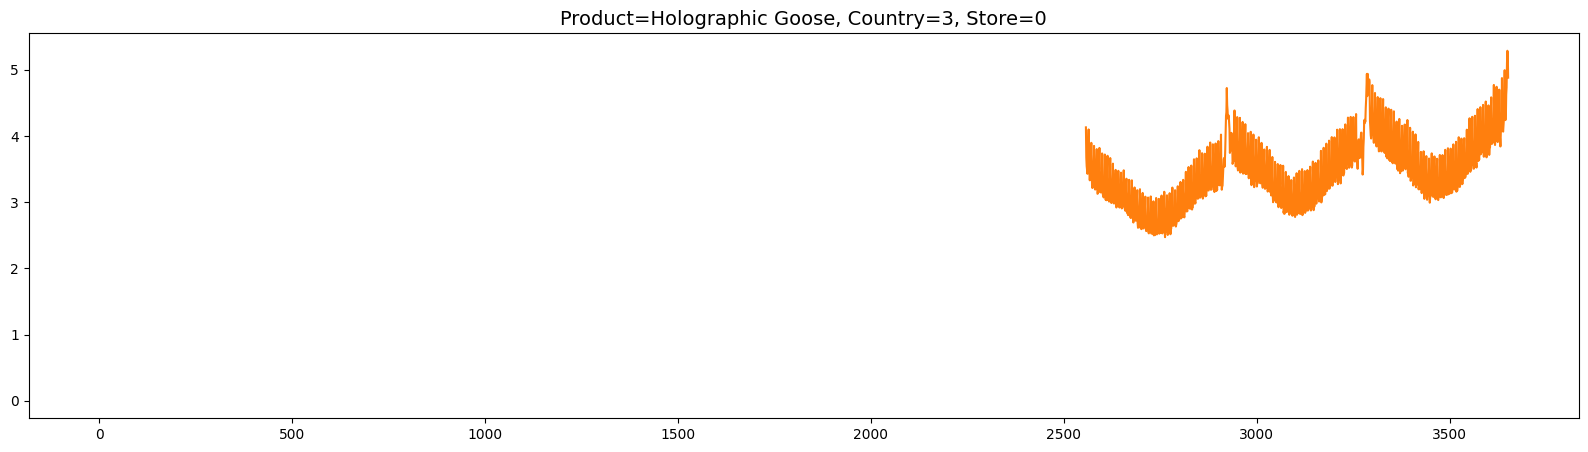

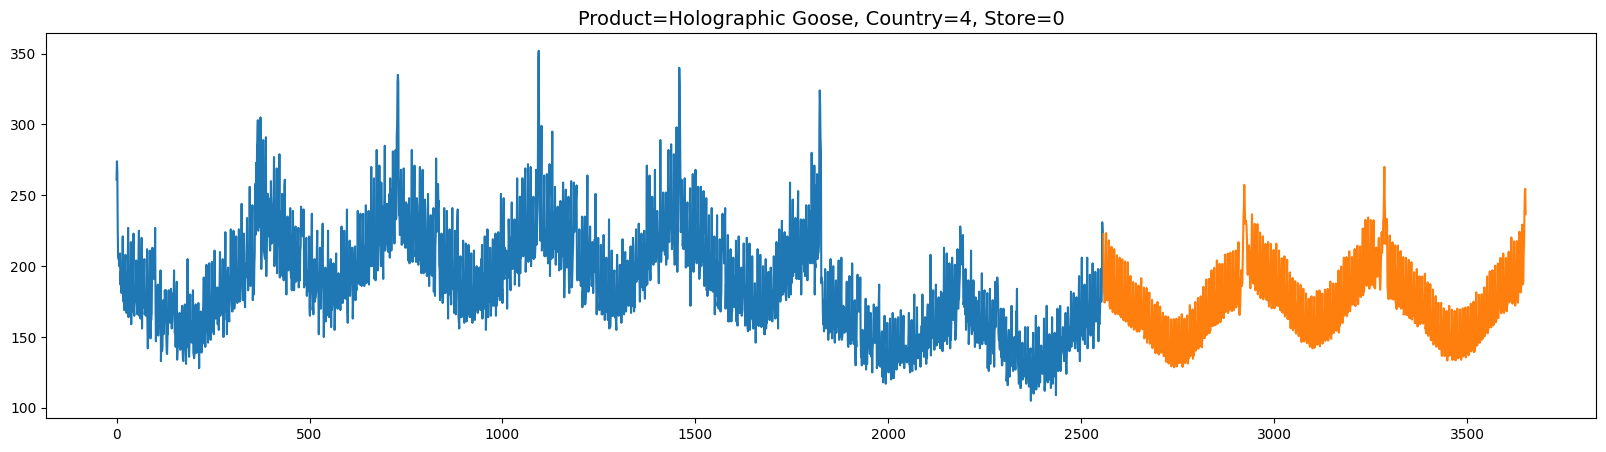

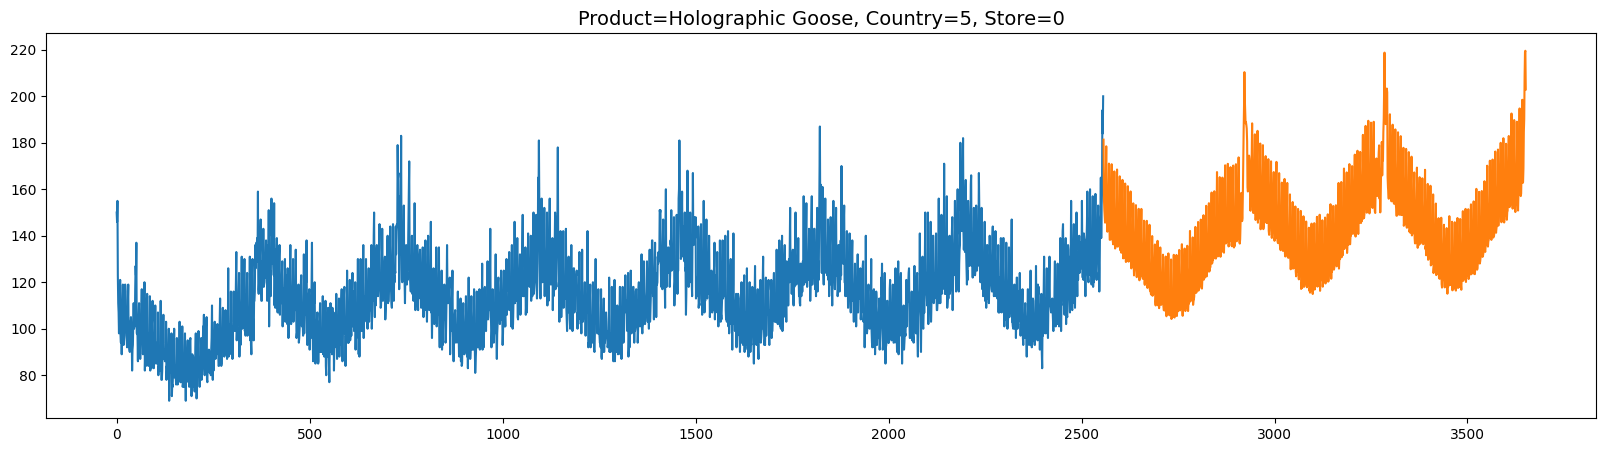

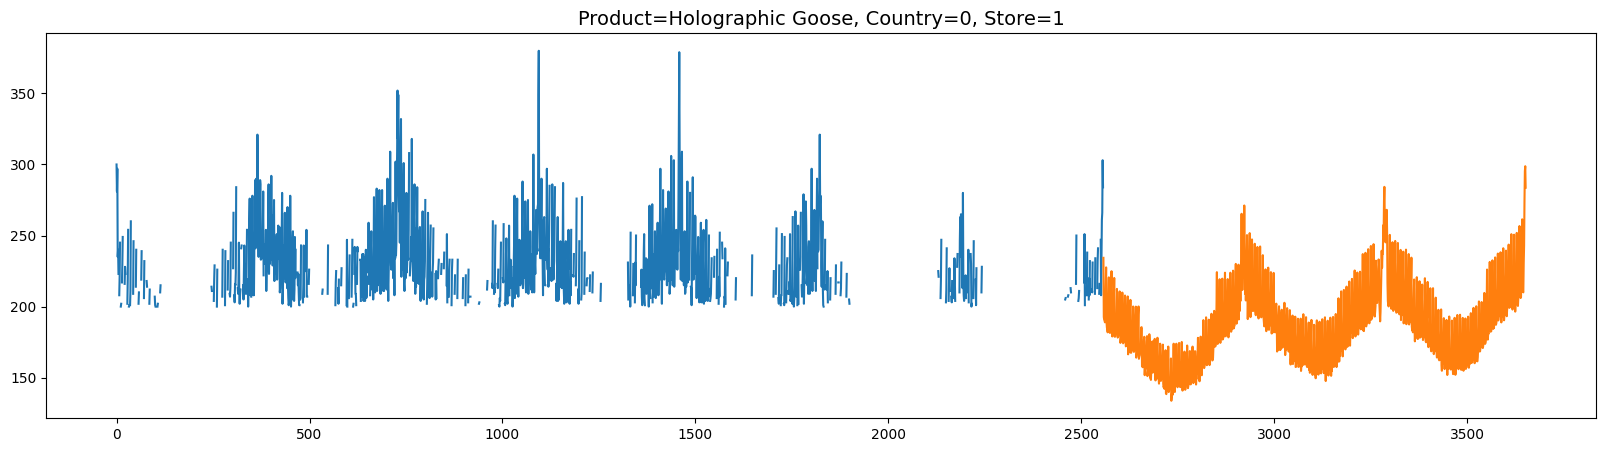

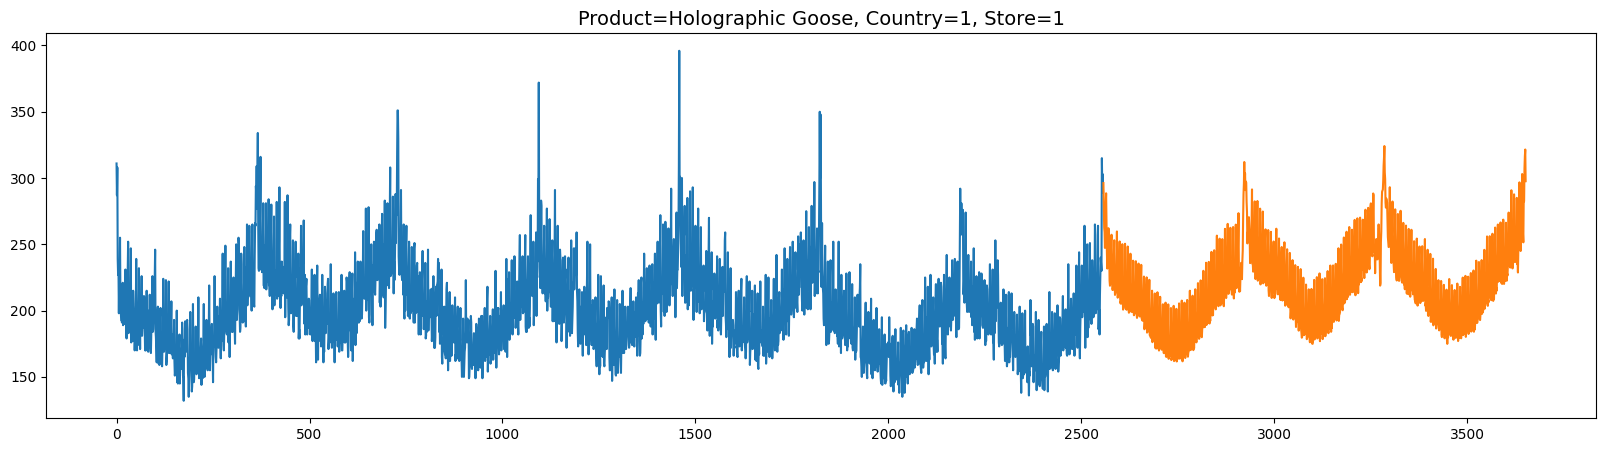

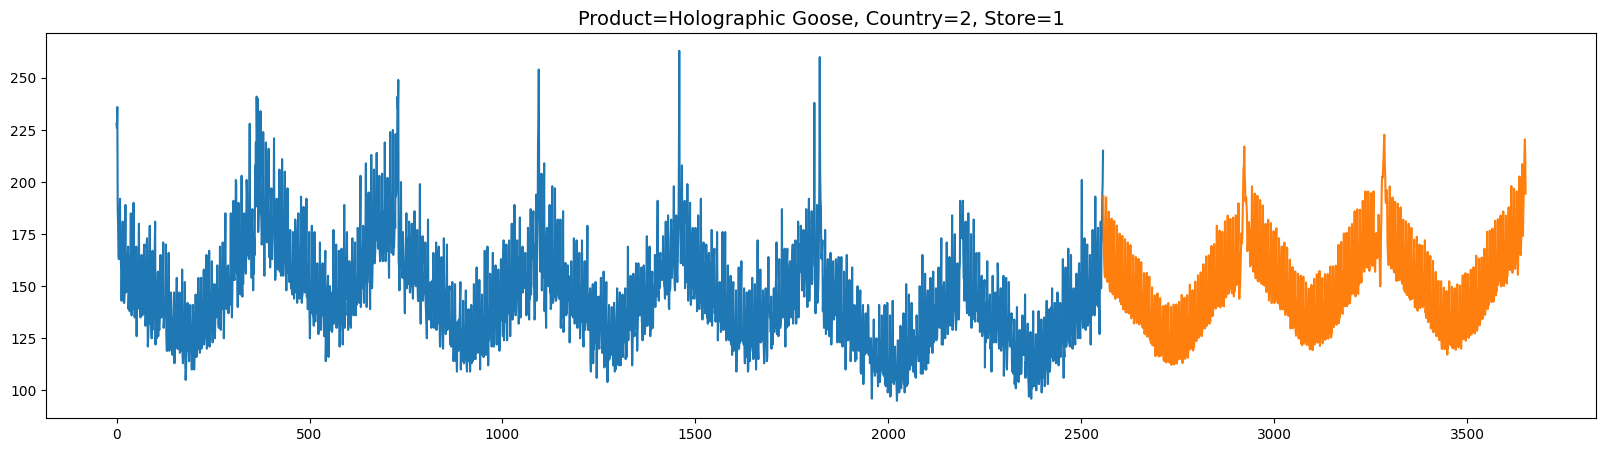

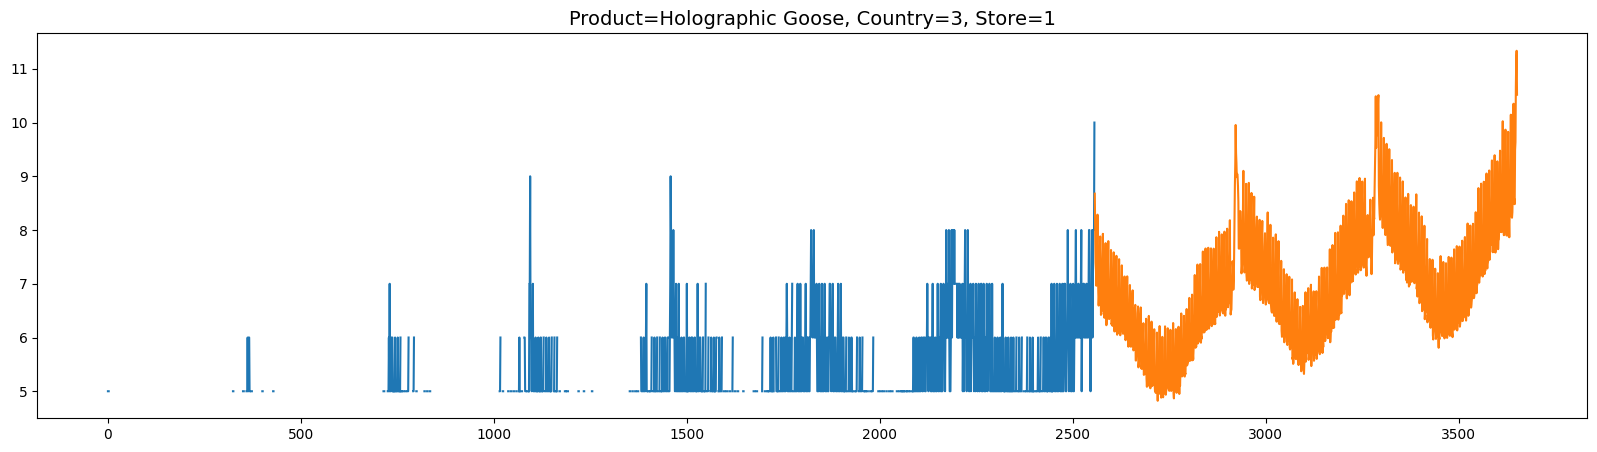

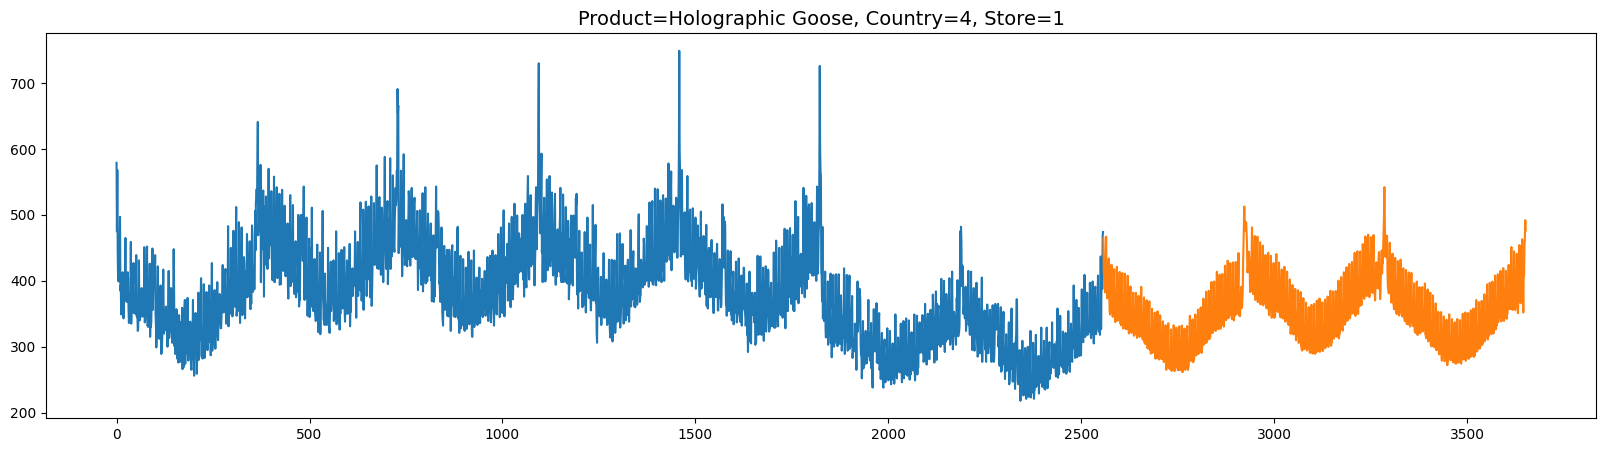

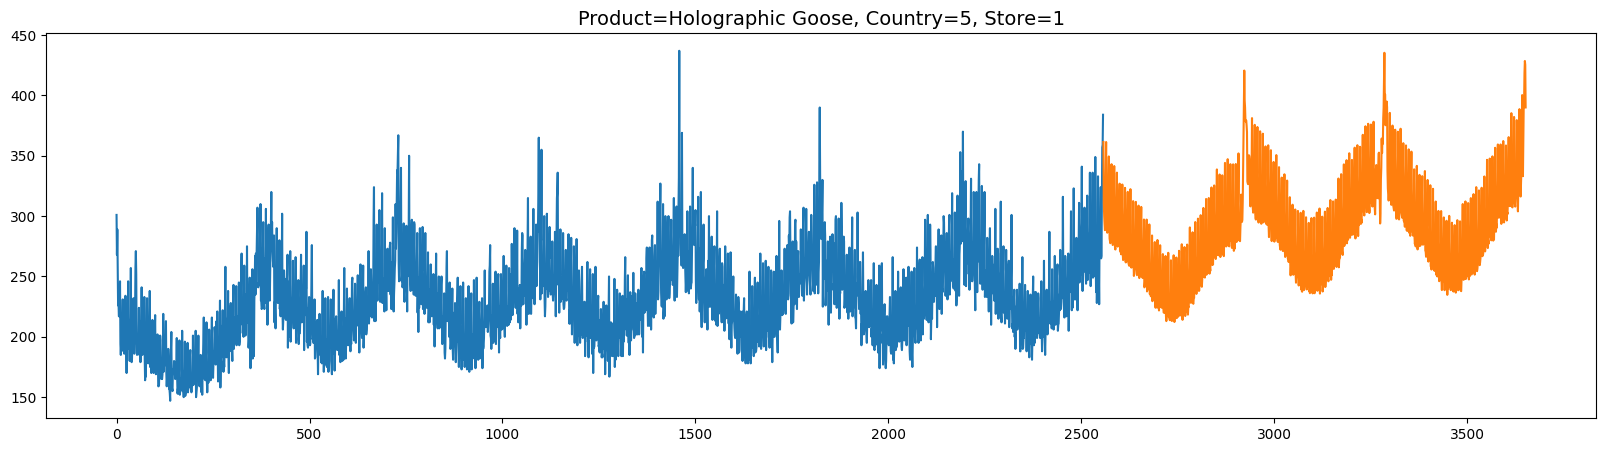

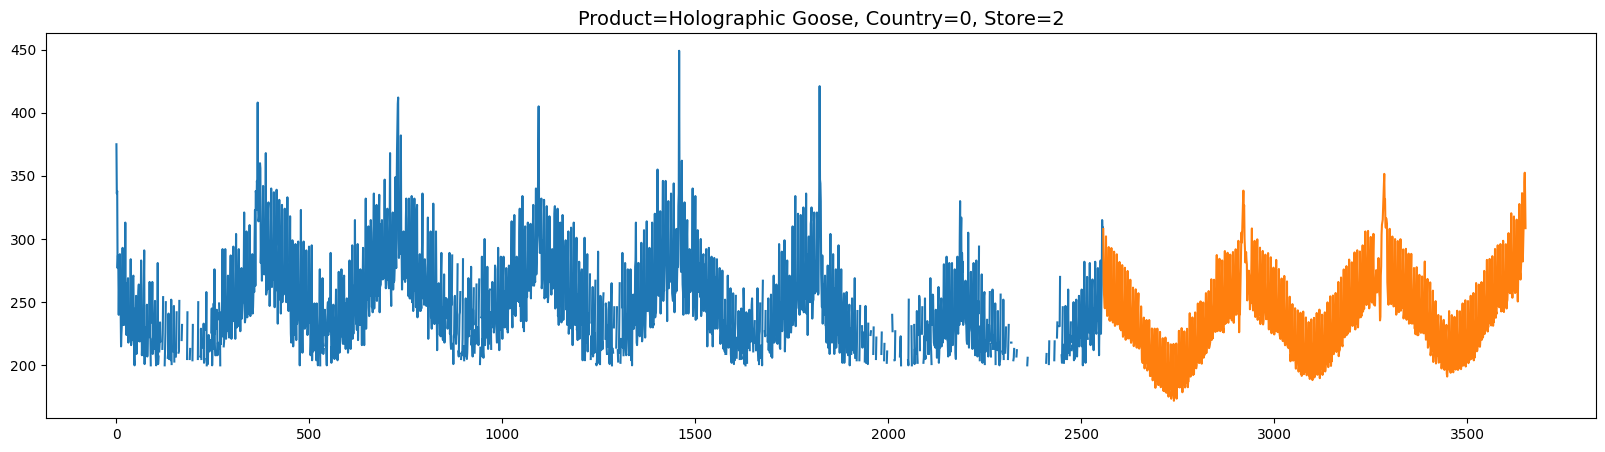

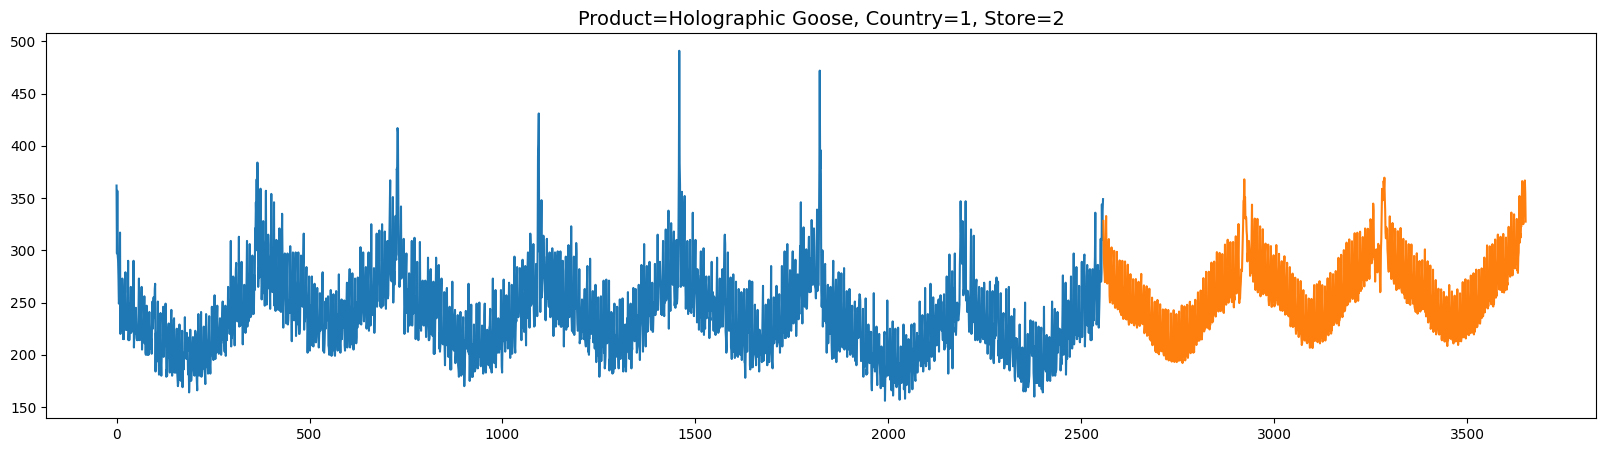

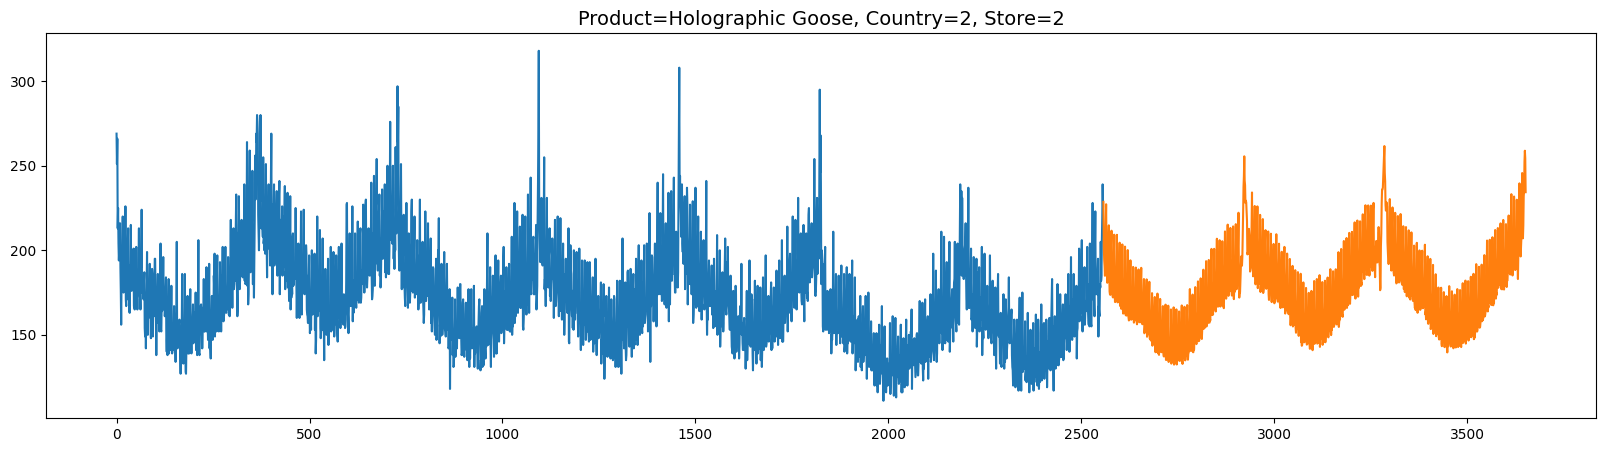

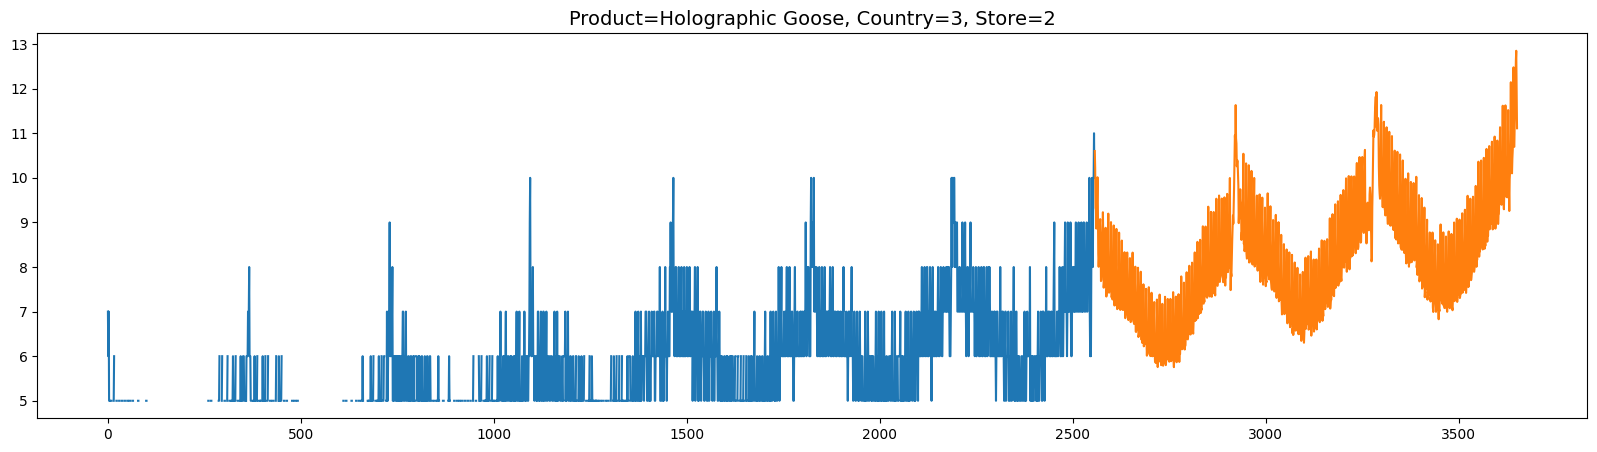

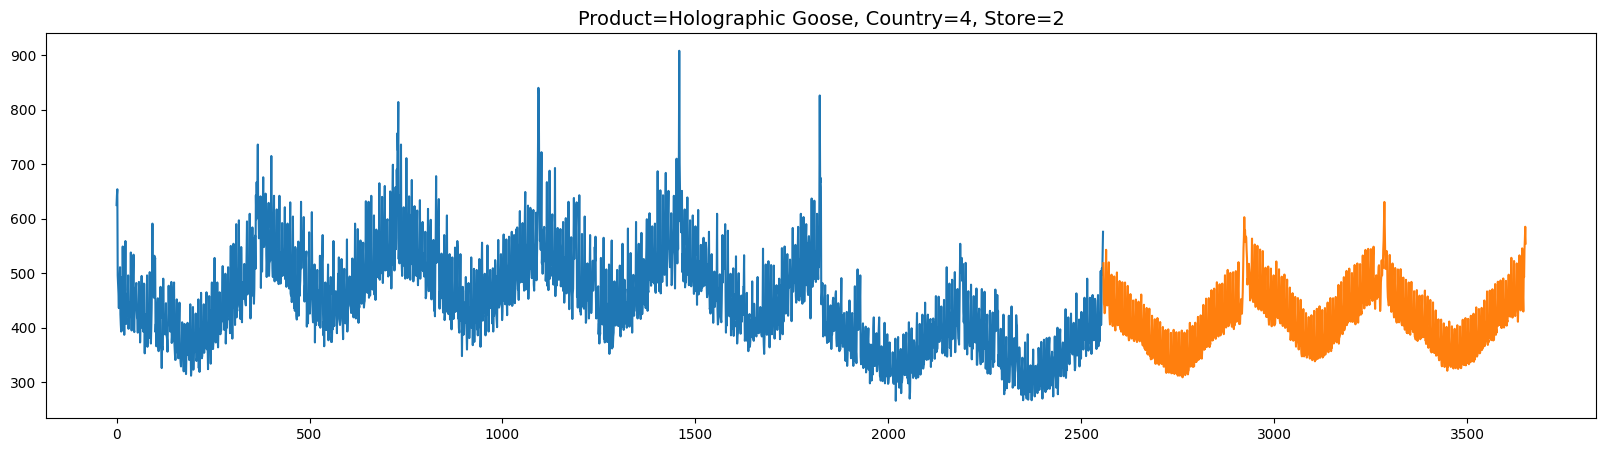

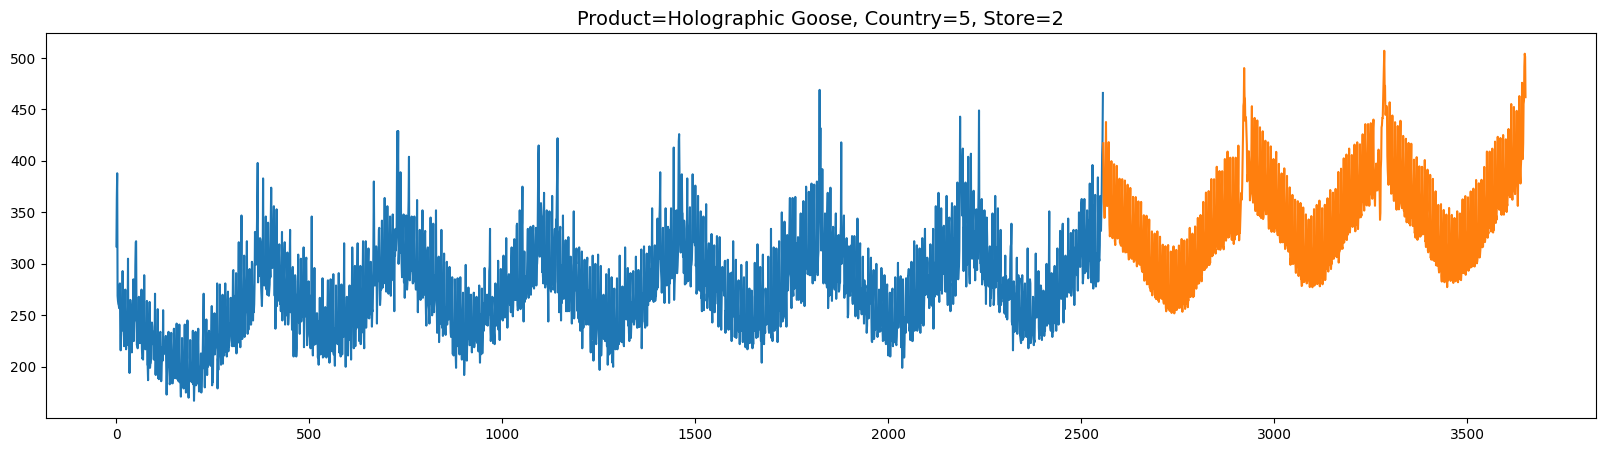

In [22]:
for ss in range(3):
    for cc in range(6):
        df1 = train.loc[(train.country==C[cc])&(train['product']==P[PROD])&(train.store==S[ss])]
        df2 = test.loc[(test.country==C[cc])&(test['product']==P[PROD])&(test.store==S[ss])]

        plt.figure(figsize=(20,5))
        tmp = df1.num_sold * df1.GDP * df1.store_ratio
        tmp.iloc[0] = np.nan_to_num( tmp.iloc[0] )
        plt.plot(np.arange(len(df1)), tmp )
        plt.plot(np.arange(len(df2))+len(df1),df2.num_sold)
        plt.title(f"Product={P[PROD]}, Country={cc}, Store={ss}",size=14)
        plt.show()

# Write Partial Submission CSV
We run this notebook 5 times with `PROD = 0,1,2,3,4`. The first 4 times write intermediate files. The last 5th time will write our `submission.csv` file to submit to competition.

In [23]:
# DELETE THIS IF YOU RUN THIS NOTEBOOK 5 TIMES AND MAKE YOUR OWN SUBMISSION.CSV
if PROD!=4:
    os.system(f"cp {PATH}submission_v1.csv submission_v1.csv")

In [24]:
if PROD<4:
    test.to_csv(f"test_v{VER}_p{PROD}.csv",index=False)
    print(f"Saved partial predictions for product {P[PROD]} (PROD = {PROD})")
    print(f"Now run this notebook again with PROD = {PROD+1} to make more predictions.")
else:
    test[['id','num_sold']].to_csv(f"submission_v{VER}.csv",index=False)
    print(f"Wrote submission_v{VER}.csv, now submit to comp!")
test[['id','num_sold']].head()

Saved partial predictions for product Holographic Goose (PROD = 0)
Now run this notebook again with PROD = 1 to make more predictions.


id    num_sold
0  230130  128.546359
1  230131    0.000000
2  230132    0.000000
3  230133    0.000000
4  230134    0.000000